## 0. Importing libraries

In [71]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from statsmodels.regression.linear_model import OLS
from scipy.stats import linregress
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from skopt import BayesSearchCV, plots
import lightgbm as lgb

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('science.mplstyle')
plt.rcParams['font.family'] = 'Times New Roman'

## Question 1

In [2]:
diamonds = pd.read_csv('diamonds.csv', index_col=0) # load the data
# recode cut, color and clarity (category to numeric)
cutDict = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
colorDict = {'D': 7, 'E': 6, 'F': 5, 'G': 4, 'H': 3, 'I': 2, 'J': 1}
clarityDict = {'IF': 8, 'VVS1': 7, 'VVS2': 6, 'VS1': 5, 'VS2': 4, 'SI1': 3, 'SI2': 2, 'I1': 1}
diamonds['cut'] = diamonds['cut'].map(cutDict)
diamonds['color'] = diamonds['color'].map(colorDict)
diamonds['clarity'] = diamonds['clarity'].map(clarityDict)
# move price to the last column (for convenience)
price = diamonds['price']
diamonds.drop(labels=['price'], axis=1, inplace=True)
diamonds.insert(9, 'price', price)

In [3]:
display(diamonds)

carat  cut  color  clarity  depth  table     x     y     z  price
1       0.23    5      6        2   61.5   55.0  3.95  3.98  2.43    330
2       0.21    4      6        3   59.8   61.0  3.89  3.84  2.31    327
3       0.23    2      6        5   56.9   65.0  4.05  4.07  2.31    328
4       0.29    4      2        4   62.4   58.0  4.20  4.23  2.63    337
5       0.31    2      1        2   63.3   58.0  4.34  4.35  2.75    338
...      ...  ...    ...      ...    ...    ...   ...   ...   ...    ...
53936   0.72    5      7        3   60.8   57.0  5.75  5.76  3.50   2758
53937   0.72    2      7        3   63.1   55.0  5.69  5.75  3.61   2759
53938   0.70    3      7        3   62.8   60.0  5.66  5.68  3.56   2760
53939   0.86    4      3        2   61.0   58.0  6.15  6.12  3.74   2757
53940   0.75    5      7        2   62.2   55.0  5.83  5.87  3.64   2761

[53940 rows x 10 columns]

In [114]:
display(diamonds.agg(['min', 'max', 'mean', 'median', 'std']).round(3).to_latex())

'\\begin{tabular}{lrrrrrrrrrr}\n\\toprule\n{} &  carat &    cut &  color &  clarity &   depth &   table &       x &       y &       z &      price \\\\\n\\midrule\nmin    &  0.200 &  1.000 &  1.000 &    1.000 &  43.000 &  43.000 &   0.000 &   0.000 &   0.000 &    327.000 \\\\\nmax    &  5.010 &  5.000 &  7.000 &    8.000 &  79.000 &  95.000 &  10.740 &  58.900 &  31.800 &  18823.000 \\\\\nmean   &  0.798 &  3.904 &  4.406 &    4.051 &  61.749 &  57.457 &   5.731 &   5.735 &   3.539 &   3934.802 \\\\\nmedian &  0.700 &  4.000 &  4.000 &    4.000 &  61.800 &  57.000 &   5.700 &   5.710 &   3.530 &   2403.000 \\\\\nstd    &  0.474 &  1.117 &  1.701 &    1.647 &   1.433 &   2.234 &   1.122 &   1.142 &   0.706 &   3989.442 \\\\\n\\bottomrule\n\\end{tabular}\n'

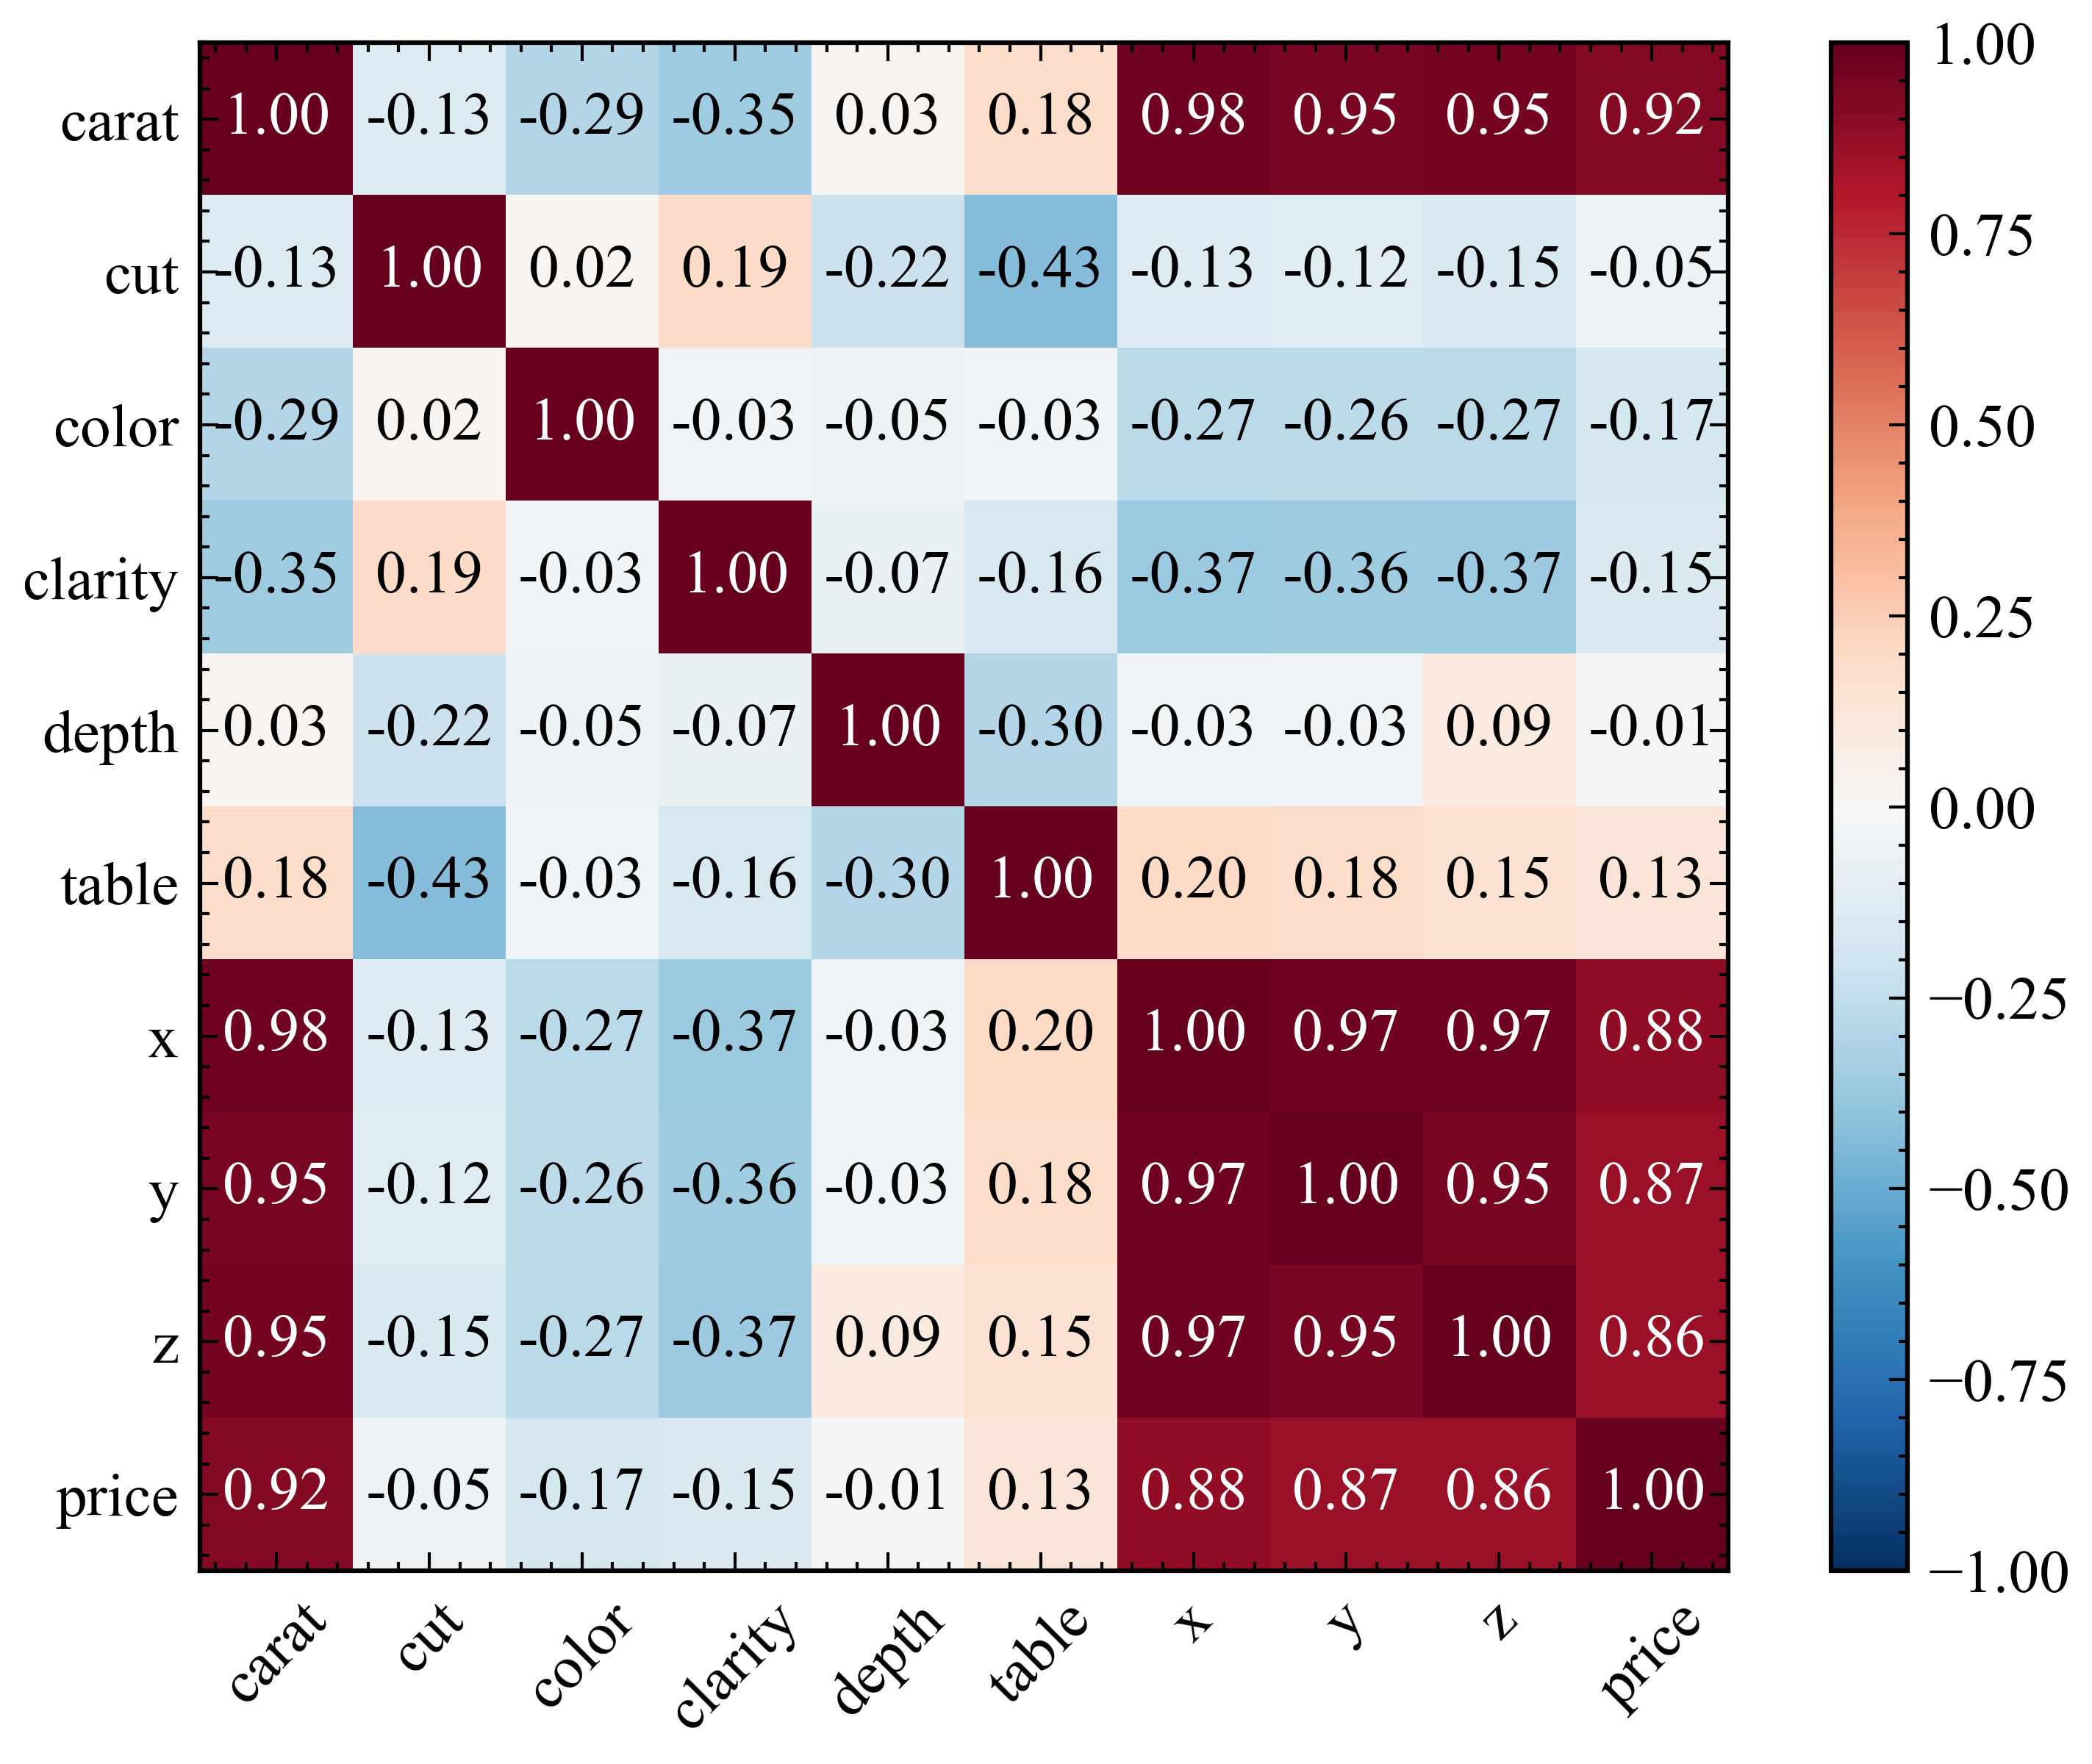

In [61]:
plt.figure(figsize=(6, 4.5), dpi=300)
corrMatrix = diamonds.corr()
plt.imshow(corrMatrix, cmap='RdBu_r', vmin=-1, vmax=1)

# add text annotations to each cell
for i in range(len(diamonds.columns)):
    for j in range(len(diamonds.columns)):
        text = f"{corrMatrix.iloc[i,j]:.2f}"
        if corrMatrix.iloc[i,j] > 0.7:
            plt.text(j, i, text, ha='center', va='center', color='w')
        else:
            plt.text(j, i, text, ha='center', va='center', color='k')

plt.xticks(range(len(diamonds.columns)), diamonds.columns, rotation=45)
plt.yticks(range(len(diamonds.columns)), diamonds.columns)
plt.colorbar()
plt.savefig('Q1_1.pdf', dpi=500, bbox_inches='tight')
plt.show()

In [105]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), dpi=300)
# dictionary of numerical features names and number of bins as values
numericalFeatures = {'carat': 100, 'depth': 100, 'table': 100, 'x': 100, 'y': 100, 'z': 100}
for i, col in enumerate(numericalFeatures):
    ax = axes[i//3][i%3]
    ax.hist(diamonds[col], bins=numericalFeatures[col])
    ax.set_title(f'Feature: {col}')
    ax.set_xlabel('values')
    ax.set_ylabel('counts')
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.text(0.95, 0.95, f"({chr(ord('a') + i)})", transform=ax.transAxes, fontsize=16, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.9, edgecolor='black'))

plt.tight_layout()
plt.savefig('Q1_2.pdf', dpi=500, bbox_inches='tight')
plt.show()

In [103]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=300)
# dictionary of categorical features names and number of bins as values
categoricalFeatures = {'cut': 5, 'color': 7, 'clarity': 8}
for i, col in enumerate(categoricalFeatures):
    ax = axes[i]
    ax.boxplot([diamonds[diamonds[col] == j]['price'] for j in range(1, categoricalFeatures[col] + 1)],flierprops = dict(markerfacecolor='r', marker='.', markersize=2))
    ax.set_title(f'Feature: {col}')
    ax.set_xlabel('categories')
    ax.set_ylabel('price')
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.text(0.95, 0.95, f"({chr(ord('a') + i)})", transform=ax.transAxes, fontsize=16, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.9, edgecolor='black'))

plt.tight_layout()
plt.savefig('Q1_3.pdf', dpi=500, bbox_inches='tight')
plt.show()

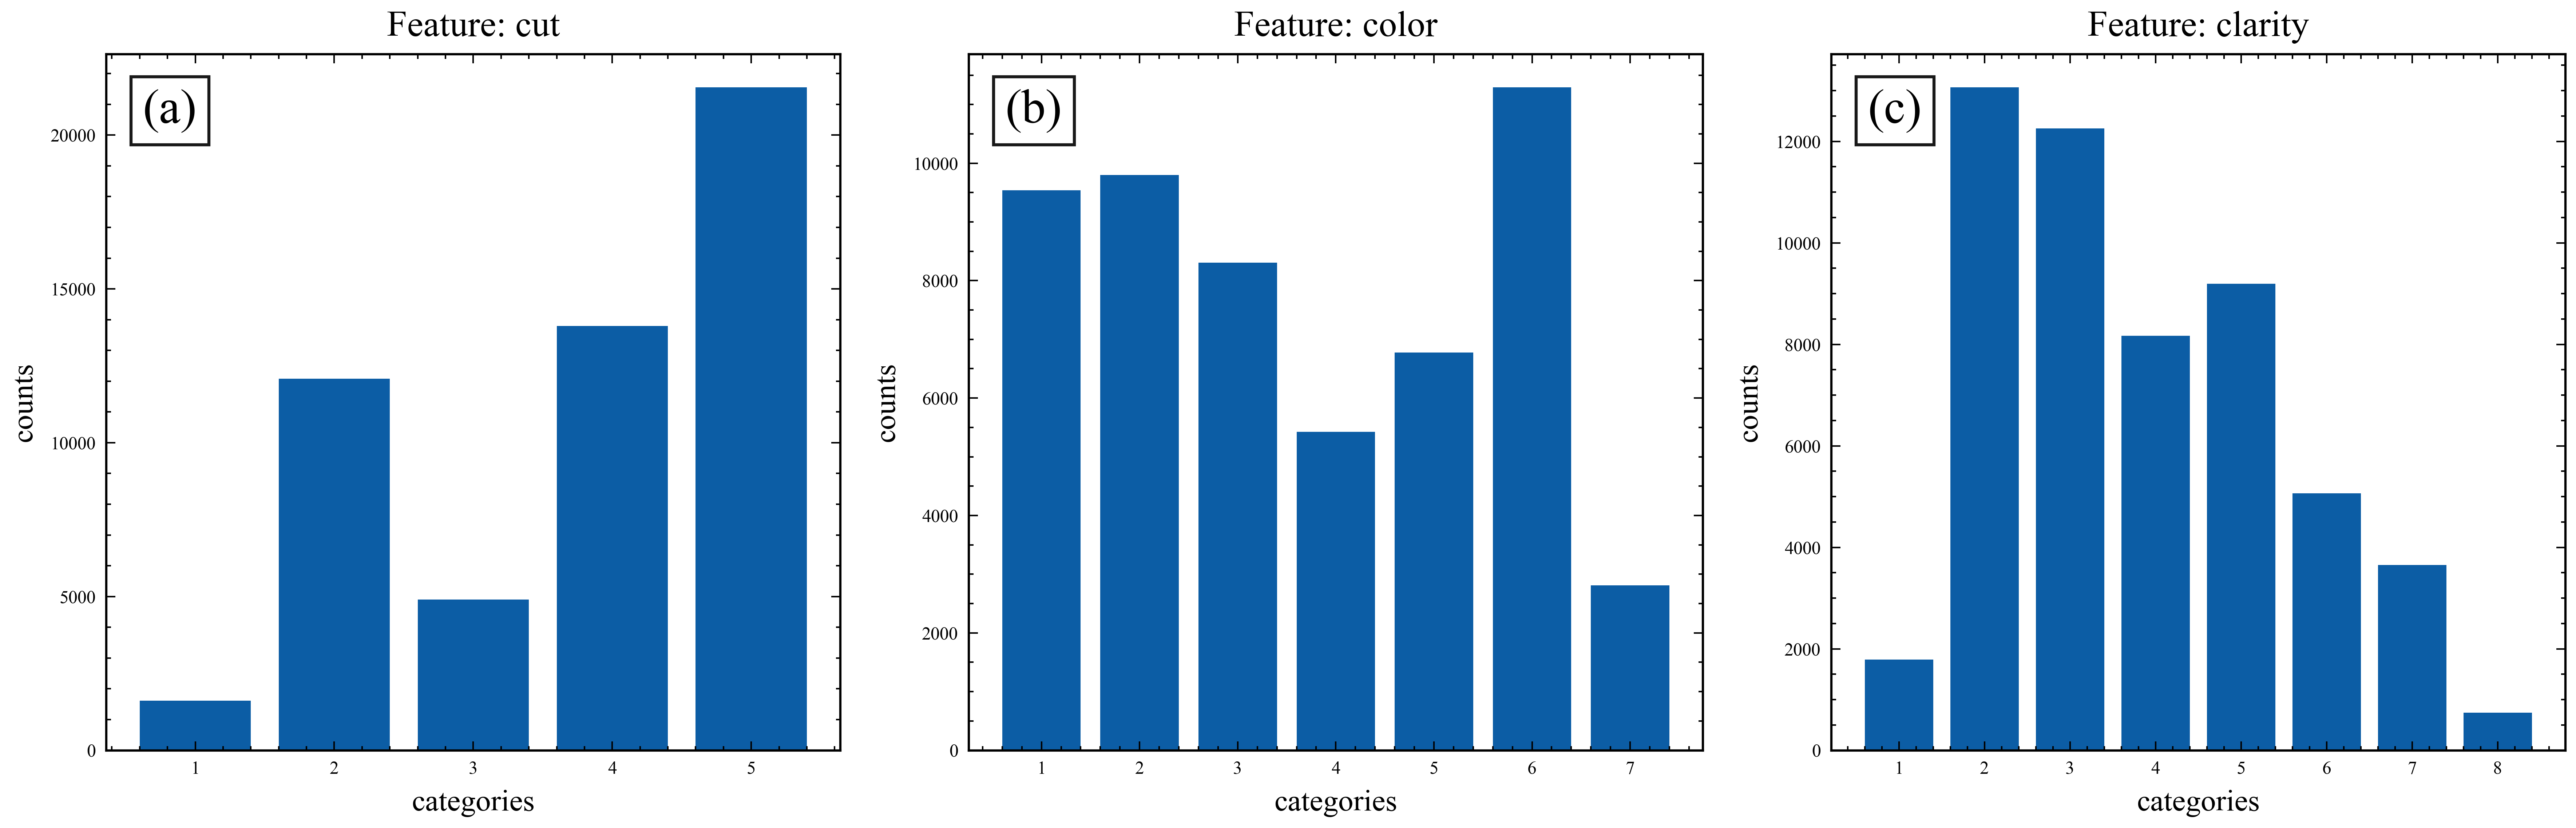

In [100]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=300)
for i, col in enumerate(categoricalFeatures):
    ax = axes[i]
    ax.bar(diamonds[col].unique(), diamonds[col].value_counts())
    ax.set_title(f'Feature: {col}')
    ax.set_xlabel('categories')
    ax.set_ylabel('counts')
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.text(0.05, 0.95, f"({chr(ord('a') + i)})", transform=ax.transAxes, fontsize=16, ha='left', va='top', bbox=dict(facecolor='white', alpha=0.9, edgecolor='black'))

plt.tight_layout()
plt.savefig('Q1_4.pdf', dpi=500, bbox_inches='tight')
plt.show()

## Question 2

In [4]:
# standardize the numerical features using StandardScaler
scaler = StandardScaler()
# creating feature and target dataframes
X = diamonds[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']]
y = diamonds['price']
# split the data into training and testing sets with a 80/20 split but keep them as dataframes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train[:] = scaler.fit_transform(X_train[:])
X_test[:] = scaler.transform(X_test[:])

In [117]:
display(X_train.agg(['min', 'max', 'mean', 'median', 'std']).round(3).to_latex())

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\n{} &  carat &    cut &  color &  clarity &   depth &   table &      x &       y &       z \\\\\n\\midrule\nmin    & -1.264 & -2.606 & -2.007 &   -1.854 & -13.123 &  -6.486 & -5.118 &  -4.999 &  -4.999 \\\\\nmax    &  8.898 &  0.981 &  1.525 &    2.397 &  12.083 &  16.840 &  4.470 &  46.330 &  39.913 \\\\\nmean   & -0.000 & -0.000 &  0.000 &    0.000 &   0.000 &   0.000 &  0.000 &  -0.000 &  -0.000 \\\\\nmedian & -0.208 &  0.085 & -0.241 &   -0.032 &   0.040 &  -0.206 & -0.029 &  -0.023 &  -0.013 \\\\\nstd    &  1.000 &  1.000 &  1.000 &    1.000 &   1.000 &   1.000 &  1.000 &   1.000 &   1.000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [23]:
# use mutual_info_regression to print the mutual information between each feature and the target
print('Mutual information between each feature and price:')
for i, col in enumerate(X_train.columns):
    print(f'{col}\t: {mutual_info_regression(X_train[[col]], y_train)[0]:.4f}')

# use f_regression to print the F-value between each feature and the target
print('\n\nF-scores for each feature and price:')
for i, col in enumerate(X_train.columns):
    print(f'{col}\t: {f_regression(X_train[[col]], y_train)[0][0]:.4f}')

Mutual information between each feature and price:
carat	: 1.6324
cut	: 0.0598
color	: 0.1359
clarity	: 0.2163
depth	: 0.0311
table	: 0.0295
x	: 1.3943
y	: 1.4112
z	: 1.3511


F-scores for each feature and price:
carat	: 243413.1232
cut	: 131.7650
color	: 1303.0035
clarity	: 944.6800
depth	: 1.3451
table	: 663.6719
x	: 154683.5746
y	: 122678.0149
z	: 119280.8776


## Question 4

In [5]:
# drop cut, depth and table features from the training and testing sets
X_train.drop(labels=['cut', 'depth', 'table'], axis=1, inplace=True)
X_test.drop(labels=['cut', 'depth', 'table'], axis=1, inplace=True)
# change X_train, y_train, X_test and y_test to numpy arrays
X_train, y_train, X_test, y_test = X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy()

In [11]:
# (a) ordinary least squares (linear regression without regularization)
linReg = LinearRegression()
errors = []
for i, (train_index, val_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=42).split(X_train, y_train)):
    linReg.fit(X_train[train_index], y_train[train_index])
    y_pred = linReg.predict(X_train[val_index])
    rmse = mean_squared_error(y_train[val_index], y_pred, squared=False)
    errors.append(rmse)
    print(f'Fold {i + 1} RMSE: {rmse:.4f}')

print('_' * 40)
print(f'Average RMSE: {np.mean(errors):.4f}')

y_pred = linReg.predict(X_test) # test the model on the testing set and print the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Test RMSE: {rmse:.4f}')

Fold 1 RMSE: 1187.5462
Fold 2 RMSE: 1210.8107
Fold 3 RMSE: 1229.8148
Fold 4 RMSE: 1199.5456
Fold 5 RMSE: 1235.5341
Fold 6 RMSE: 1369.0840
Fold 7 RMSE: 1228.7260
Fold 8 RMSE: 1202.0551
Fold 9 RMSE: 1251.1406
Fold 10 RMSE: 1239.3556
________________________________________
Average RMSE: 1235.3613
Test RMSE: 1237.4270


In [7]:
# (b) Lasso regression
# selecting alpha for Lasso regression using cross-validation
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
errAlpha = []
for alpha in tqdm(alphas):
    lassoReg = Lasso(alpha=alpha)
    errors = []
    for i, (train_index, val_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=42).split(X_train, y_train)):
        lassoReg.fit(X_train[train_index], y_train[train_index])
        y_pred = lassoReg.predict(X_train[val_index])
        rmse = mean_squared_error(y_train[val_index], y_pred, squared=False)
        errors.append(rmse)
    errAlpha.append(np.mean(errors))

100%|██████████| 8/8 [00:37<00:00,  4.74s/it]


In [8]:
# plotting the Average RMSE for each alpha value on a log scale
plt.figure(figsize=(6, 3), dpi=300)
plt.plot(alphas, errAlpha)
plt.axvline(x=alphas[np.argmin(errAlpha)], color='red', linestyle='--')
plt.text(alphas[np.argmin(errAlpha)] + 0.1, np.min(errAlpha) + 5, f'alpha = {alphas[np.argmin(errAlpha)]:.2f}')
plt.xscale('log')
plt.xlabel('alpha value for Lasso regression')
plt.ylabel('Average RMSE')
plt.xticks(size=8)
plt.yticks(size=8)
plt.savefig('Q4_1.pdf', dpi=500, bbox_inches='tight')
plt.show()

In [12]:
lassoReg = Lasso(alpha=1.0)
errors = []
for i, (train_index, val_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=42).split(X_train, y_train)):
    lassoReg.fit(X_train[train_index], y_train[train_index])
    y_pred = lassoReg.predict(X_train[val_index])
    rmse = mean_squared_error(y_train[val_index], y_pred, squared=False)
    errors.append(rmse)
    print(f'Fold {i + 1} RMSE: {rmse:.4f}')

print('_' * 40)
print(f'Average RMSE\t: {np.mean(errors):.4f}')
y_pred = lassoReg.predict(X_test) # test the model on the testing set and print the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Test RMSE\t: {rmse:.4f}')

Fold 1 RMSE: 1187.1392
Fold 2 RMSE: 1211.4649
Fold 3 RMSE: 1230.2265
Fold 4 RMSE: 1197.6157
Fold 5 RMSE: 1236.0600
Fold 6 RMSE: 1367.4727
Fold 7 RMSE: 1229.3490
Fold 8 RMSE: 1202.9165
Fold 9 RMSE: 1244.2072
Fold 10 RMSE: 1238.8332
________________________________________
Average RMSE	: 1234.5285
Test RMSE	: 1237.5132


In [127]:
# TODO Pending (all values are zeroes for some reason).
# calculate the p-values for each feature using scipy.stats.linregress
p_values1 = []
#X_train += np.random.randn(X_train.shape[0], X_train.shape[1])
#y_train = scaler.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
for i in range(X_train.shape[1]):
    p_values1.append(linregress(X_train[:,i], y_train)[3])

# calculate the p-values for each feature using statsmodels.regression.linear_model.OLS
p_values2 = []
for i in range(X_train.shape[1]):
    model = OLS(y_train, X_train[:, i])
    results = model.fit()
    p_values2.append(results.pvalues[0])

print('_' * 40)
# print the p-values for each feature
print('p-values for each feature (computed using scipy.stats.linregress):')
for i,p in enumerate(p_values1):
    print(f'{i}\t: {p}')
print('_' * 40)
print('p-values for each feature (computed using statsmodels.regression.linear_model.OLS):')
for i,p in enumerate(p_values2):
    print(f'{i}\t: {p}')

________________________________________
p-values for each feature (computed using scipy.stats.linregress):
0	: 0.0
1	: 1.8648990212369652e-30
2	: 3.934628735055294e-281
3	: 3.1415591907384697e-205
4	: 0.246141599407869
5	: 2.9933609154946438e-145
6	: 0.0
7	: 0.0
8	: 0.0
________________________________________
p-values for each feature (computed using statsmodels.regression.linear_model.OLS):
0	: 0.0
1	: 3.434567384518724e-16
2	: 2.8210752551563308e-142
3	: 2.584241187695462e-104
4	: 0.40932357789384766
5	: 3.3842475647776912e-74
6	: 0.0
7	: 0.0
8	: 0.0


In [13]:
# (c) Ridge regression

# selecting alpha for Ridge regression using cross-validation
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
errAlpha = []
for alpha in tqdm(alphas):
    ridgeReg = Ridge(alpha=alpha)
    errors = []
    for i, (train_index, val_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=42).split(X_train, y_train)):
        ridgeReg.fit(X_train[train_index], y_train[train_index])
        y_pred = ridgeReg.predict(X_train[val_index])
        rmse = mean_squared_error(y_train[val_index], y_pred, squared=False)
        errors.append(rmse)
    errAlpha.append(np.mean(errors))
    #print(f'Average RMSE for alpha = {alpha}: {np.mean(errors):.4f}')

100%|██████████| 8/8 [00:00<00:00, 27.76it/s]


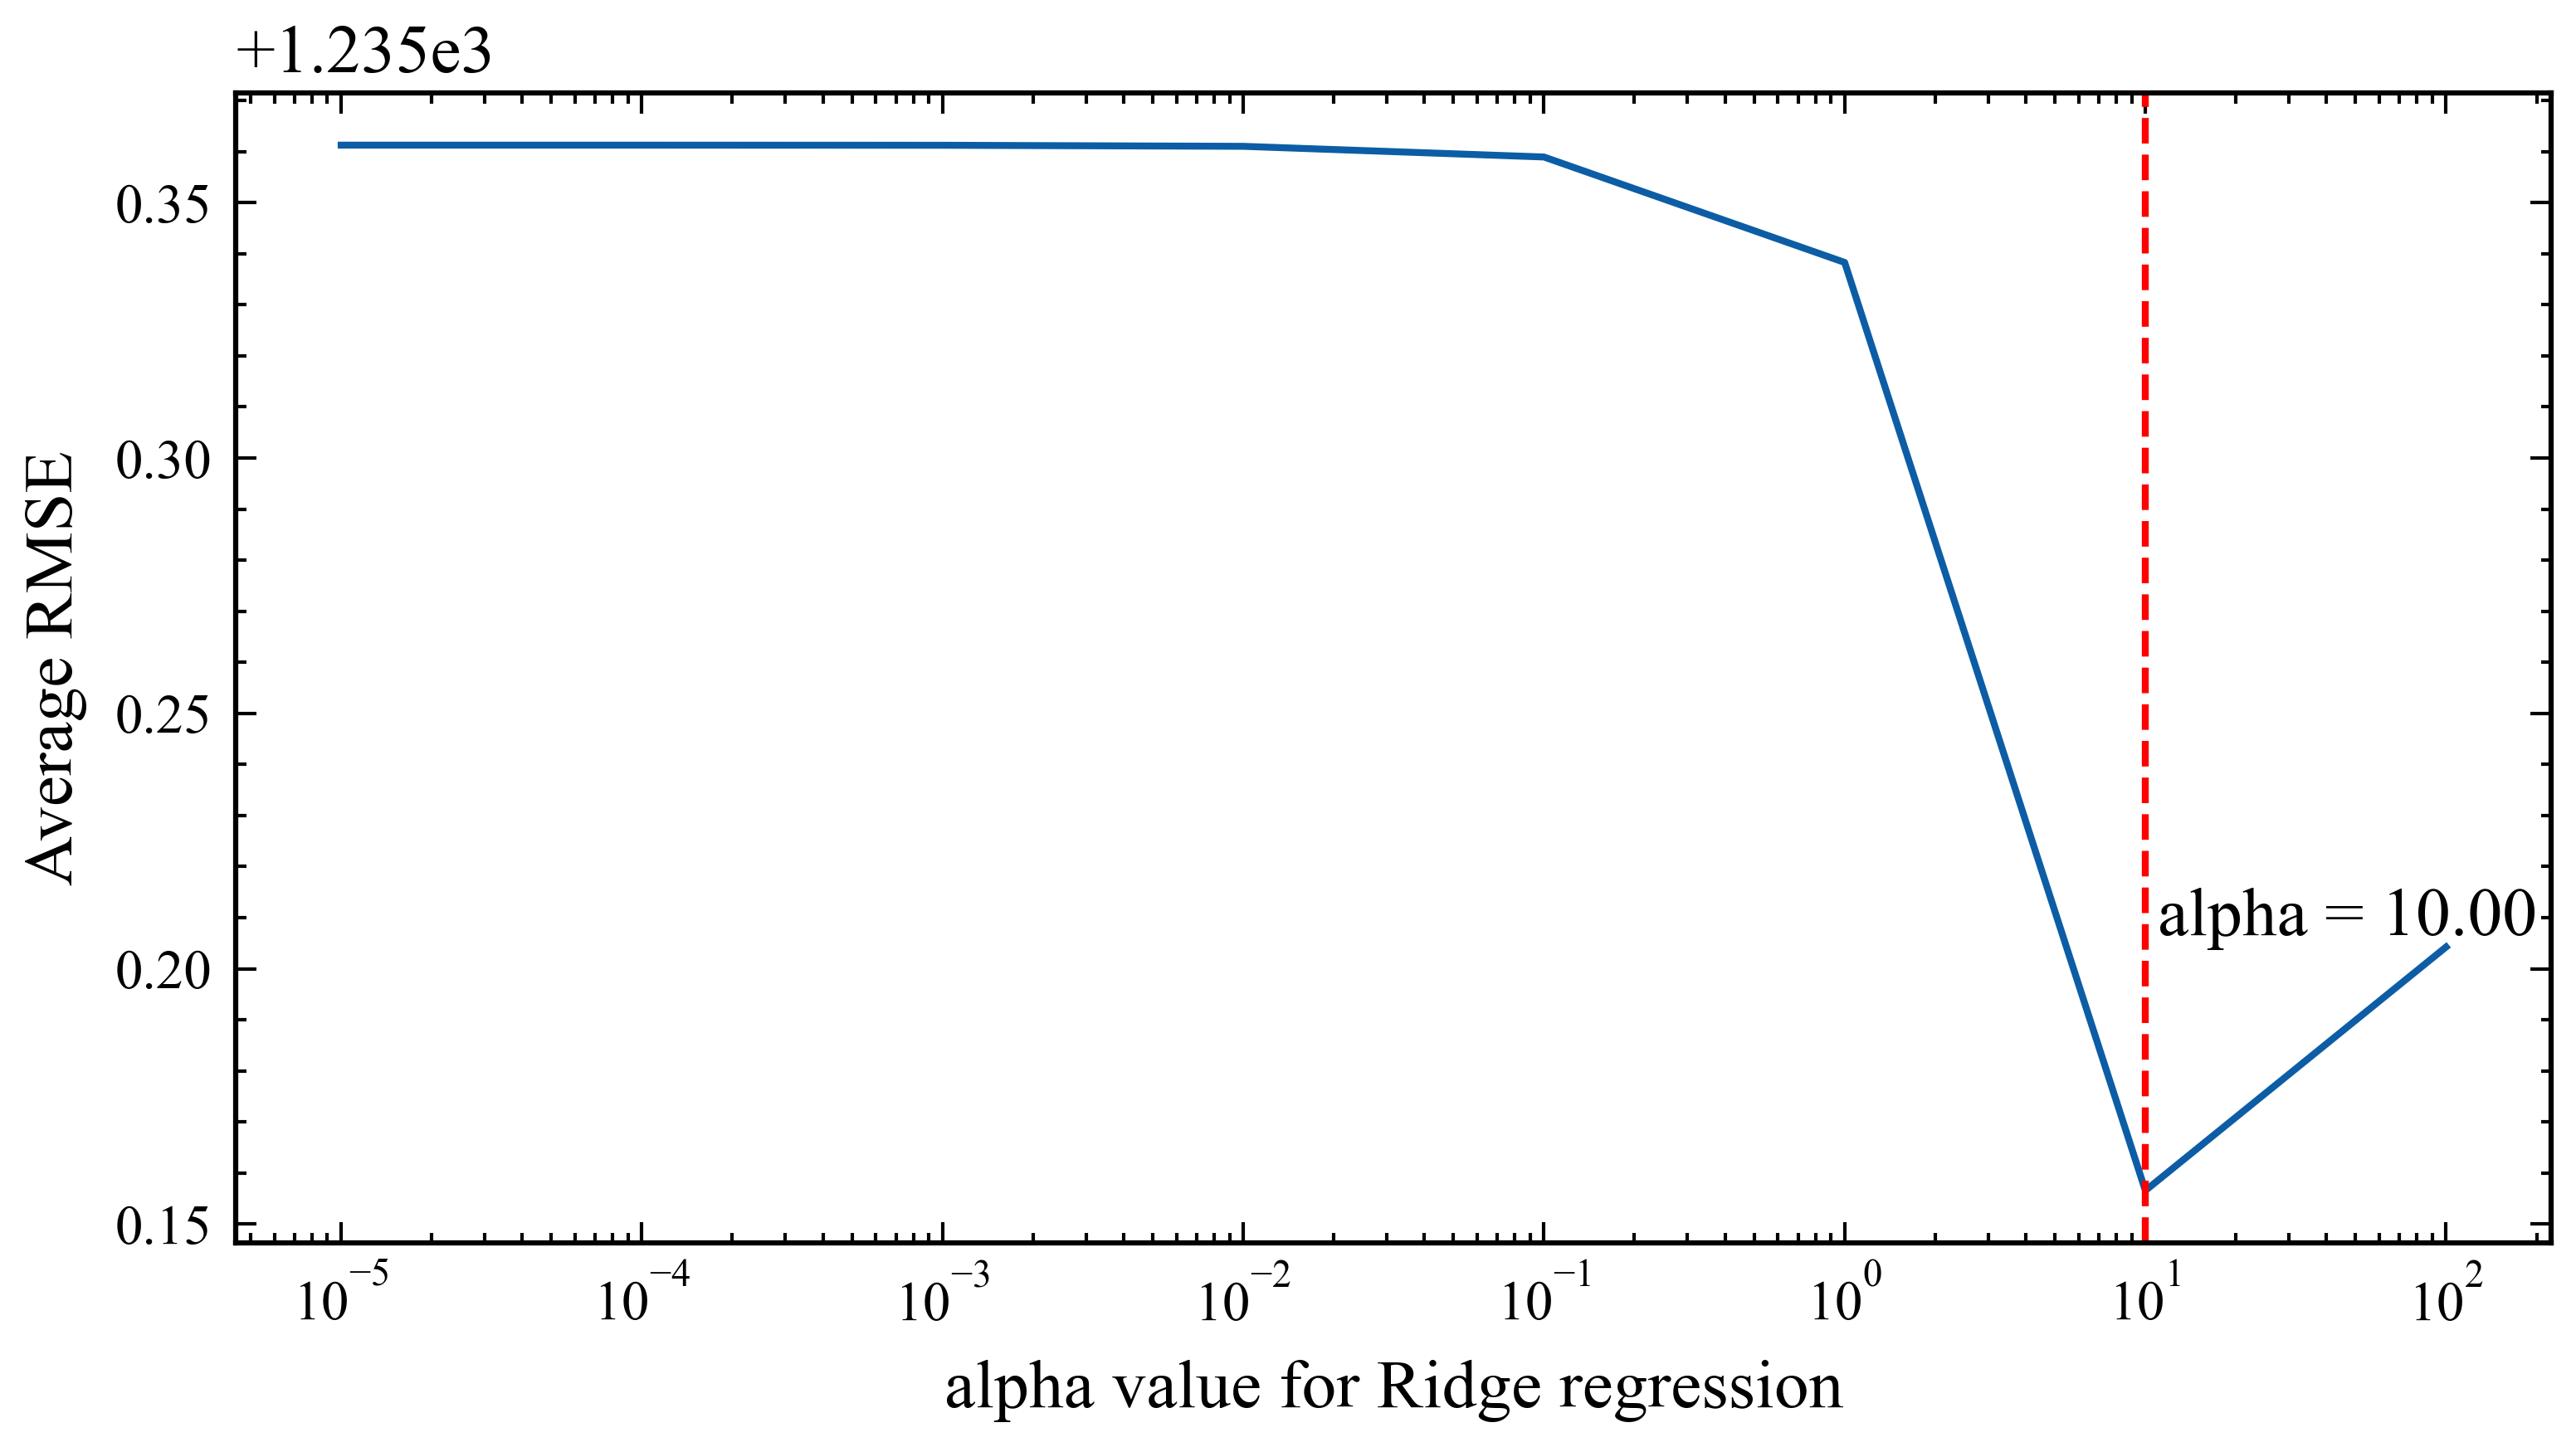

In [14]:
# plotting the Average RMSE for each alpha value on a log scale
plt.figure(figsize=(6, 3), dpi=300)
plt.plot(alphas, errAlpha)
plt.axvline(x=alphas[np.argmin(errAlpha)], color='red', linestyle='--')
plt.text(alphas[np.argmin(errAlpha)] + 1, np.min(errAlpha) + 0.05, f'alpha = {alphas[np.argmin(errAlpha)]:.2f}')
plt.xscale('log')
plt.xlabel('alpha value for Ridge regression')
plt.ylabel('Average RMSE')
plt.xticks(size=8)
plt.yticks(size=8)
plt.savefig('Q4_2.pdf', dpi=500, bbox_inches='tight')
plt.show()

In [15]:
ridgeReg = Ridge(alpha=10.0)
errors = []
for i, (train_index, val_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=42).split(X_train, y_train)):
    ridgeReg.fit(X_train[train_index], y_train[train_index])
    y_pred = ridgeReg.predict(X_train[val_index])
    rmse = mean_squared_error(y_train[val_index], y_pred, squared=False)
    errors.append(rmse)
    print(f'Fold {i + 1} RMSE: {rmse:.4f}')

print('_' * 40)
print(f'Average RMSE\t: {np.mean(errors):.4f}')
y_pred = ridgeReg.predict(X_test) # test the model on the testing set and print the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Test RMSE\t: {rmse:.4f}')

Fold 1 RMSE: 1187.2613
Fold 2 RMSE: 1211.1645
Fold 3 RMSE: 1229.9712
Fold 4 RMSE: 1198.9863
Fold 5 RMSE: 1235.8347
Fold 6 RMSE: 1367.6657
Fold 7 RMSE: 1229.0974
Fold 8 RMSE: 1202.5677
Fold 9 RMSE: 1250.1510
Fold 10 RMSE: 1238.8657
________________________________________
Average RMSE	: 1235.1566
Test RMSE	: 1237.3416


In [35]:
# Performing ridge regression again with no standard scaling this time:
# selecting alpha for Ridge regression using cross-validation
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
errAlpha = []
for alpha in tqdm(alphas):
    ridgeReg = Ridge(alpha=alpha)
    errors = []
    for i, (train_index, val_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=42).split(X_train, y_train)):
        ridgeReg.fit(X_train[train_index], y_train[train_index])
        y_pred = ridgeReg.predict(X_train[val_index])
        rmse = mean_squared_error(y_train[val_index], y_pred, squared=False)
        errors.append(rmse)
    errAlpha.append(np.mean(errors))

100%|██████████| 8/8 [00:00<00:00, 25.49it/s]


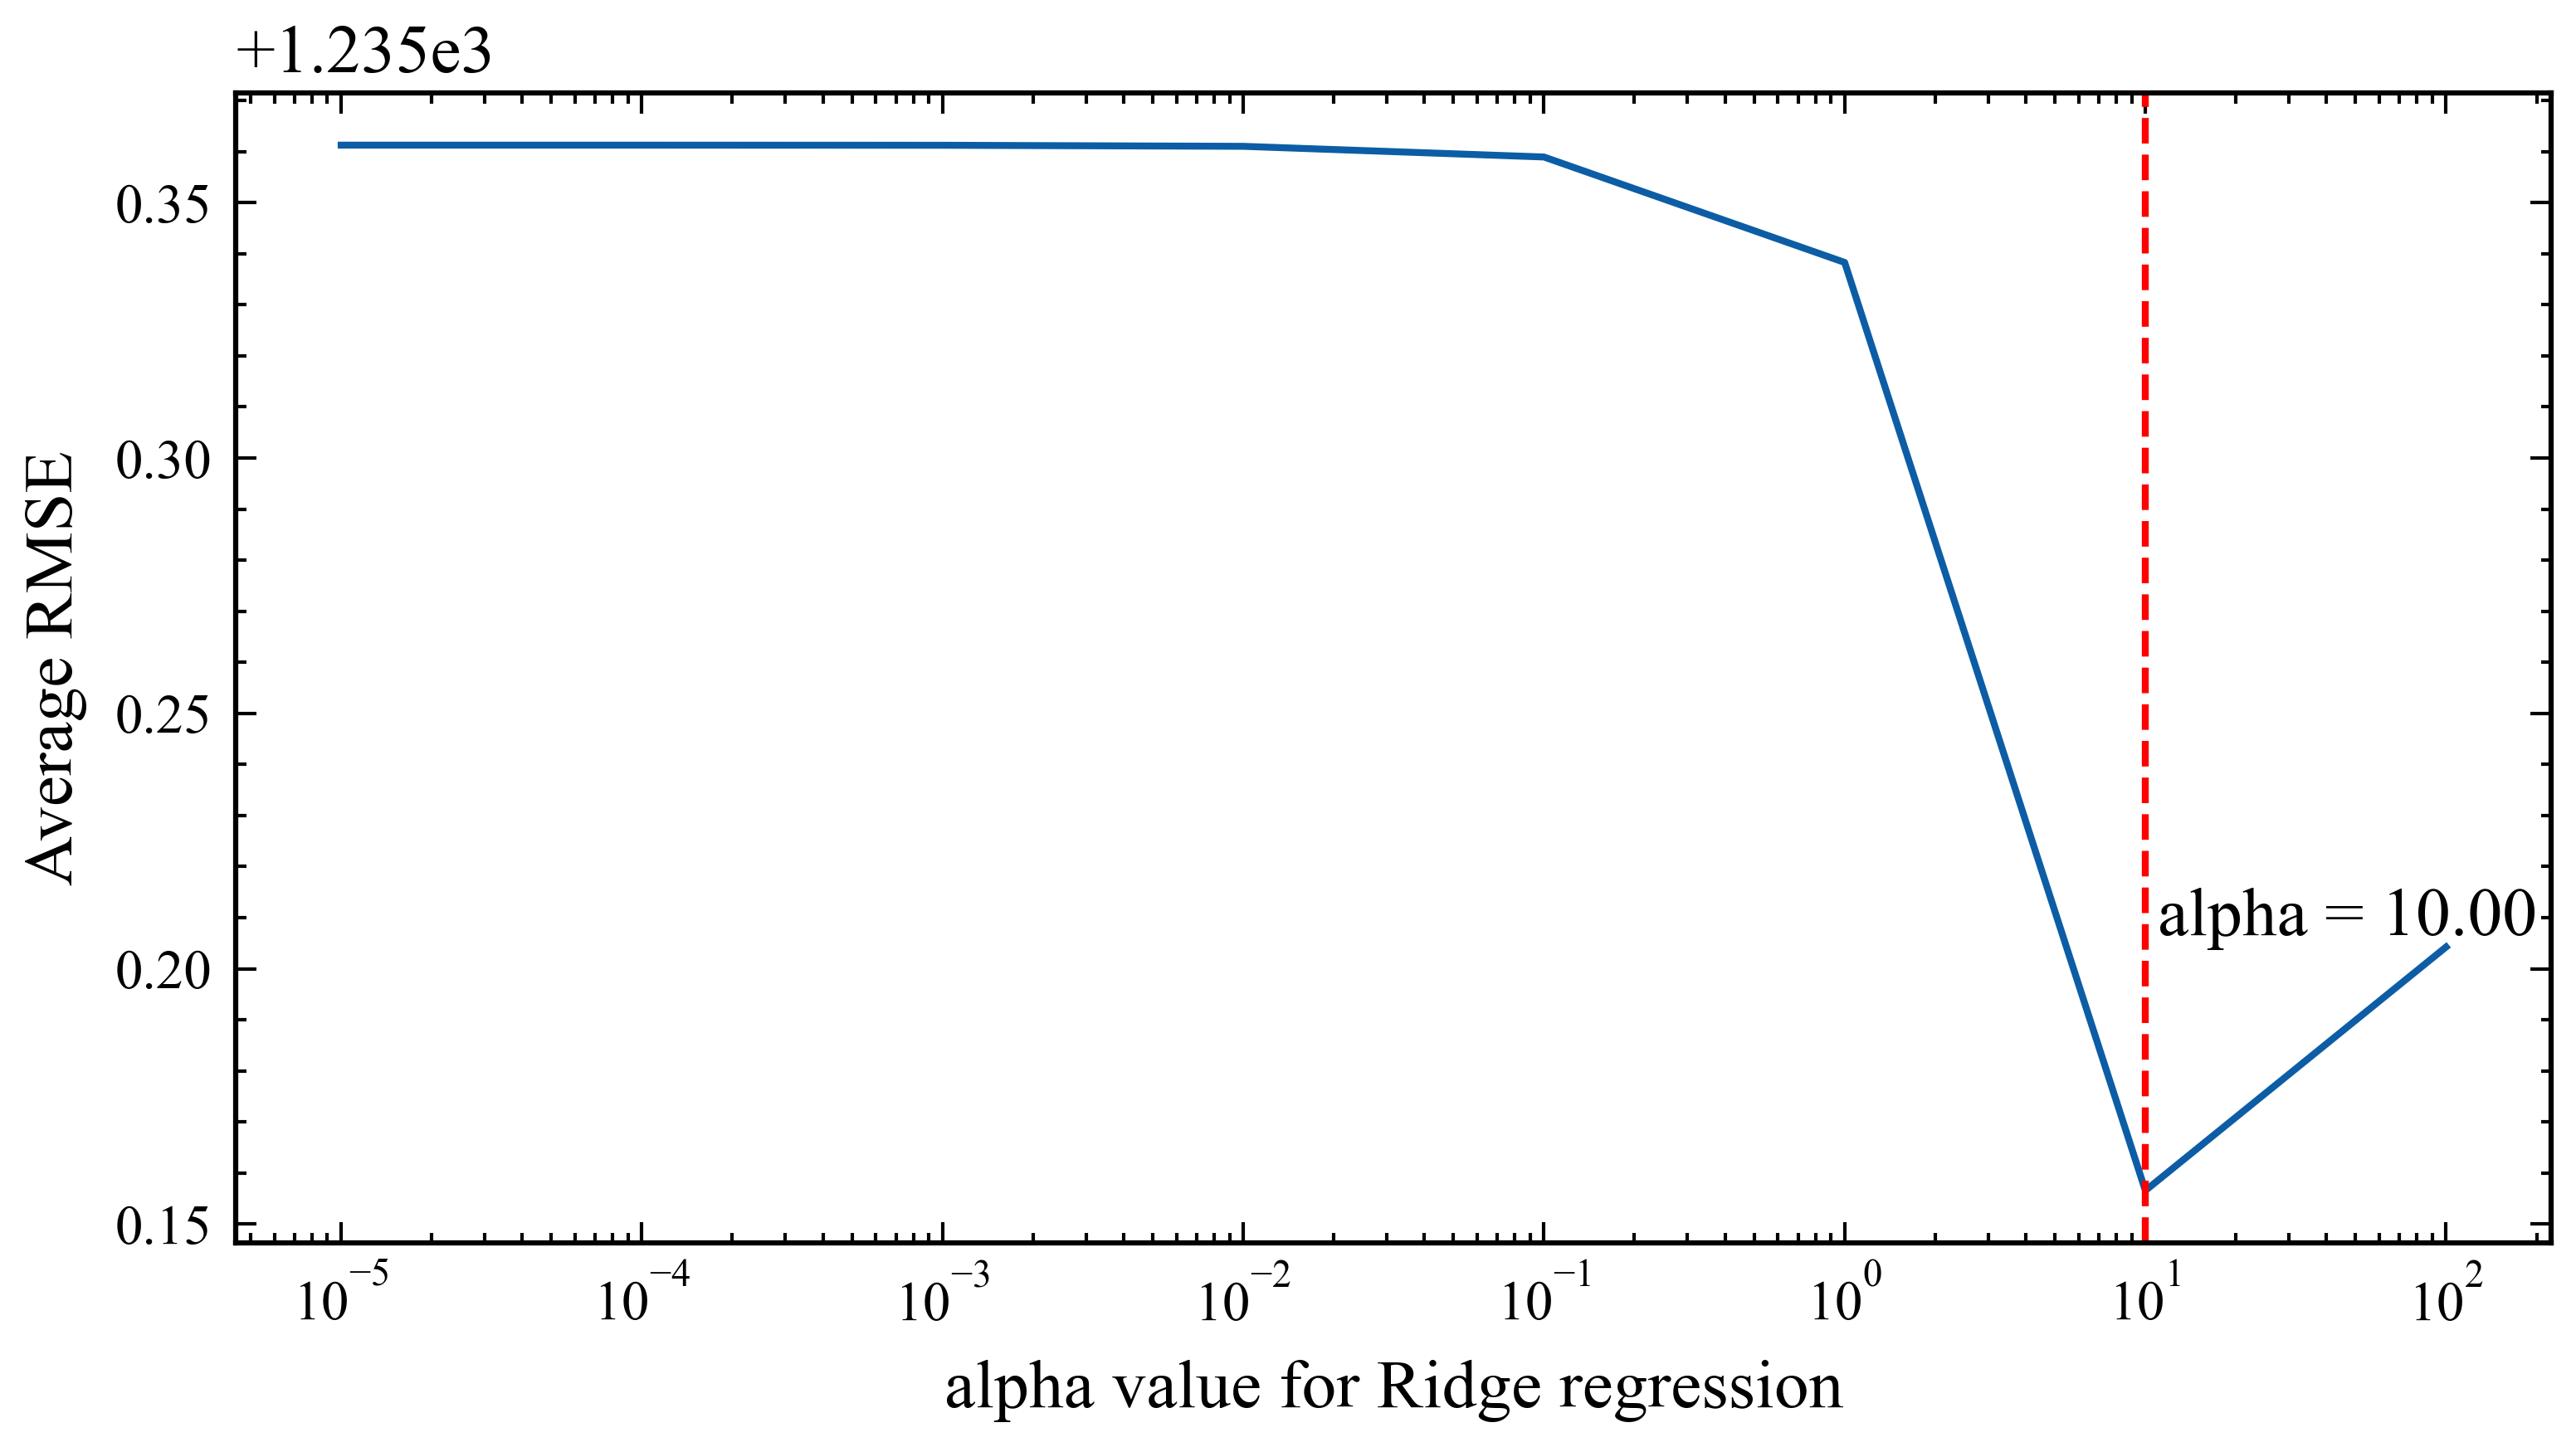

In [36]:
plt.figure(figsize=(6, 3), dpi=300)
plt.plot(alphas, errAlpha)
plt.axvline(x=alphas[np.argmin(errAlpha)], color='red', linestyle='--')
plt.text(alphas[np.argmin(errAlpha)] + 1, np.min(errAlpha) + 0.05, f'alpha = {alphas[np.argmin(errAlpha)]:.2f}')
plt.xscale('log')
plt.xlabel('alpha value for Ridge regression')
plt.ylabel('Average RMSE')
plt.xticks(size=8)
plt.yticks(size=8)
plt.savefig('Q4_3.pdf', dpi=500, bbox_inches='tight')
plt.show()

In [147]:
ridgeReg = Ridge(alpha=10.0)
errors = []
for i, (train_index, val_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=42).split(X_train, y_train)):
    ridgeReg.fit(X_train[train_index], y_train[train_index])
    y_pred = ridgeReg.predict(X_train[val_index])
    rmse = mean_squared_error(y_train[val_index], y_pred, squared=False)
    errors.append(rmse)
    print(f'Fold {i + 1} RMSE: {rmse:.4f}')

print('_' * 40)
print(f'Average RMSE\t: {np.mean(errors):.4f}')
y_pred = ridgeReg.predict(X_test) # test the model on the testing set and print the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Test RMSE\t: {rmse:.4f}')

Fold 1 RMSE: 1186.7554
Fold 2 RMSE: 1212.4337
Fold 3 RMSE: 1230.6386
Fold 4 RMSE: 1197.4356
Fold 5 RMSE: 1236.8905
Fold 6 RMSE: 1363.6852
Fold 7 RMSE: 1230.3959
Fold 8 RMSE: 1204.2515
Fold 9 RMSE: 1251.2960
Fold 10 RMSE: 1237.7283
________________________________________
Average RMSE	: 1235.1511
Test RMSE	: 1237.3087


## Question 5

In [20]:
# perform polynomial regression on the training set and use ridge regression on compound features
errDegree = []
for d in range(2, 7):
    print('_'*80)
    poly = PolynomialFeatures(degree=d, interaction_only=True)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # selecting alpha for Ridge regression using cross-validation
    alphas = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]
    errAlpha = []
    for alpha in alphas:
        ridgeReg = Ridge(alpha=alpha)
        errors = []
        for i, (train_index, val_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=42).split(X_train_poly, y_train)):
            ridgeReg.fit(X_train_poly[train_index], y_train[train_index])
            y_pred = ridgeReg.predict(X_train_poly[val_index])
            rmse = mean_squared_error(y_train[val_index], y_pred, squared=False)
            errors.append(rmse)
        errAlpha.append(np.mean(errors))
        print(f'Average RMSE for degree = {d}, alpha = {alpha} \t: {np.mean(errors):.4f}')
    errDegree.append(errAlpha)

________________________________________________________________________________
Average RMSE for degree = 2, alpha = 0.001 	: 1913.6404
Average RMSE for degree = 2, alpha = 0.01 	: 1913.4749
Average RMSE for degree = 2, alpha = 0.1 	: 1911.8255
Average RMSE for degree = 2, alpha = 1.0 	: 1895.8281
Average RMSE for degree = 2, alpha = 10 	: 1771.2462
Average RMSE for degree = 2, alpha = 100 	: 1357.1883
Average RMSE for degree = 2, alpha = 1000 	: 1060.0623
________________________________________________________________________________
Average RMSE for degree = 3, alpha = 0.001 	: 4401.6607
Average RMSE for degree = 3, alpha = 0.01 	: 4396.5196
Average RMSE for degree = 3, alpha = 0.1 	: 4347.1826
Average RMSE for degree = 3, alpha = 1.0 	: 3994.0258
Average RMSE for degree = 3, alpha = 10 	: 3075.7723
Average RMSE for degree = 3, alpha = 100 	: 2152.9632
Average RMSE for degree = 3, alpha = 1000 	: 1433.3109
____________________________________________________________________________

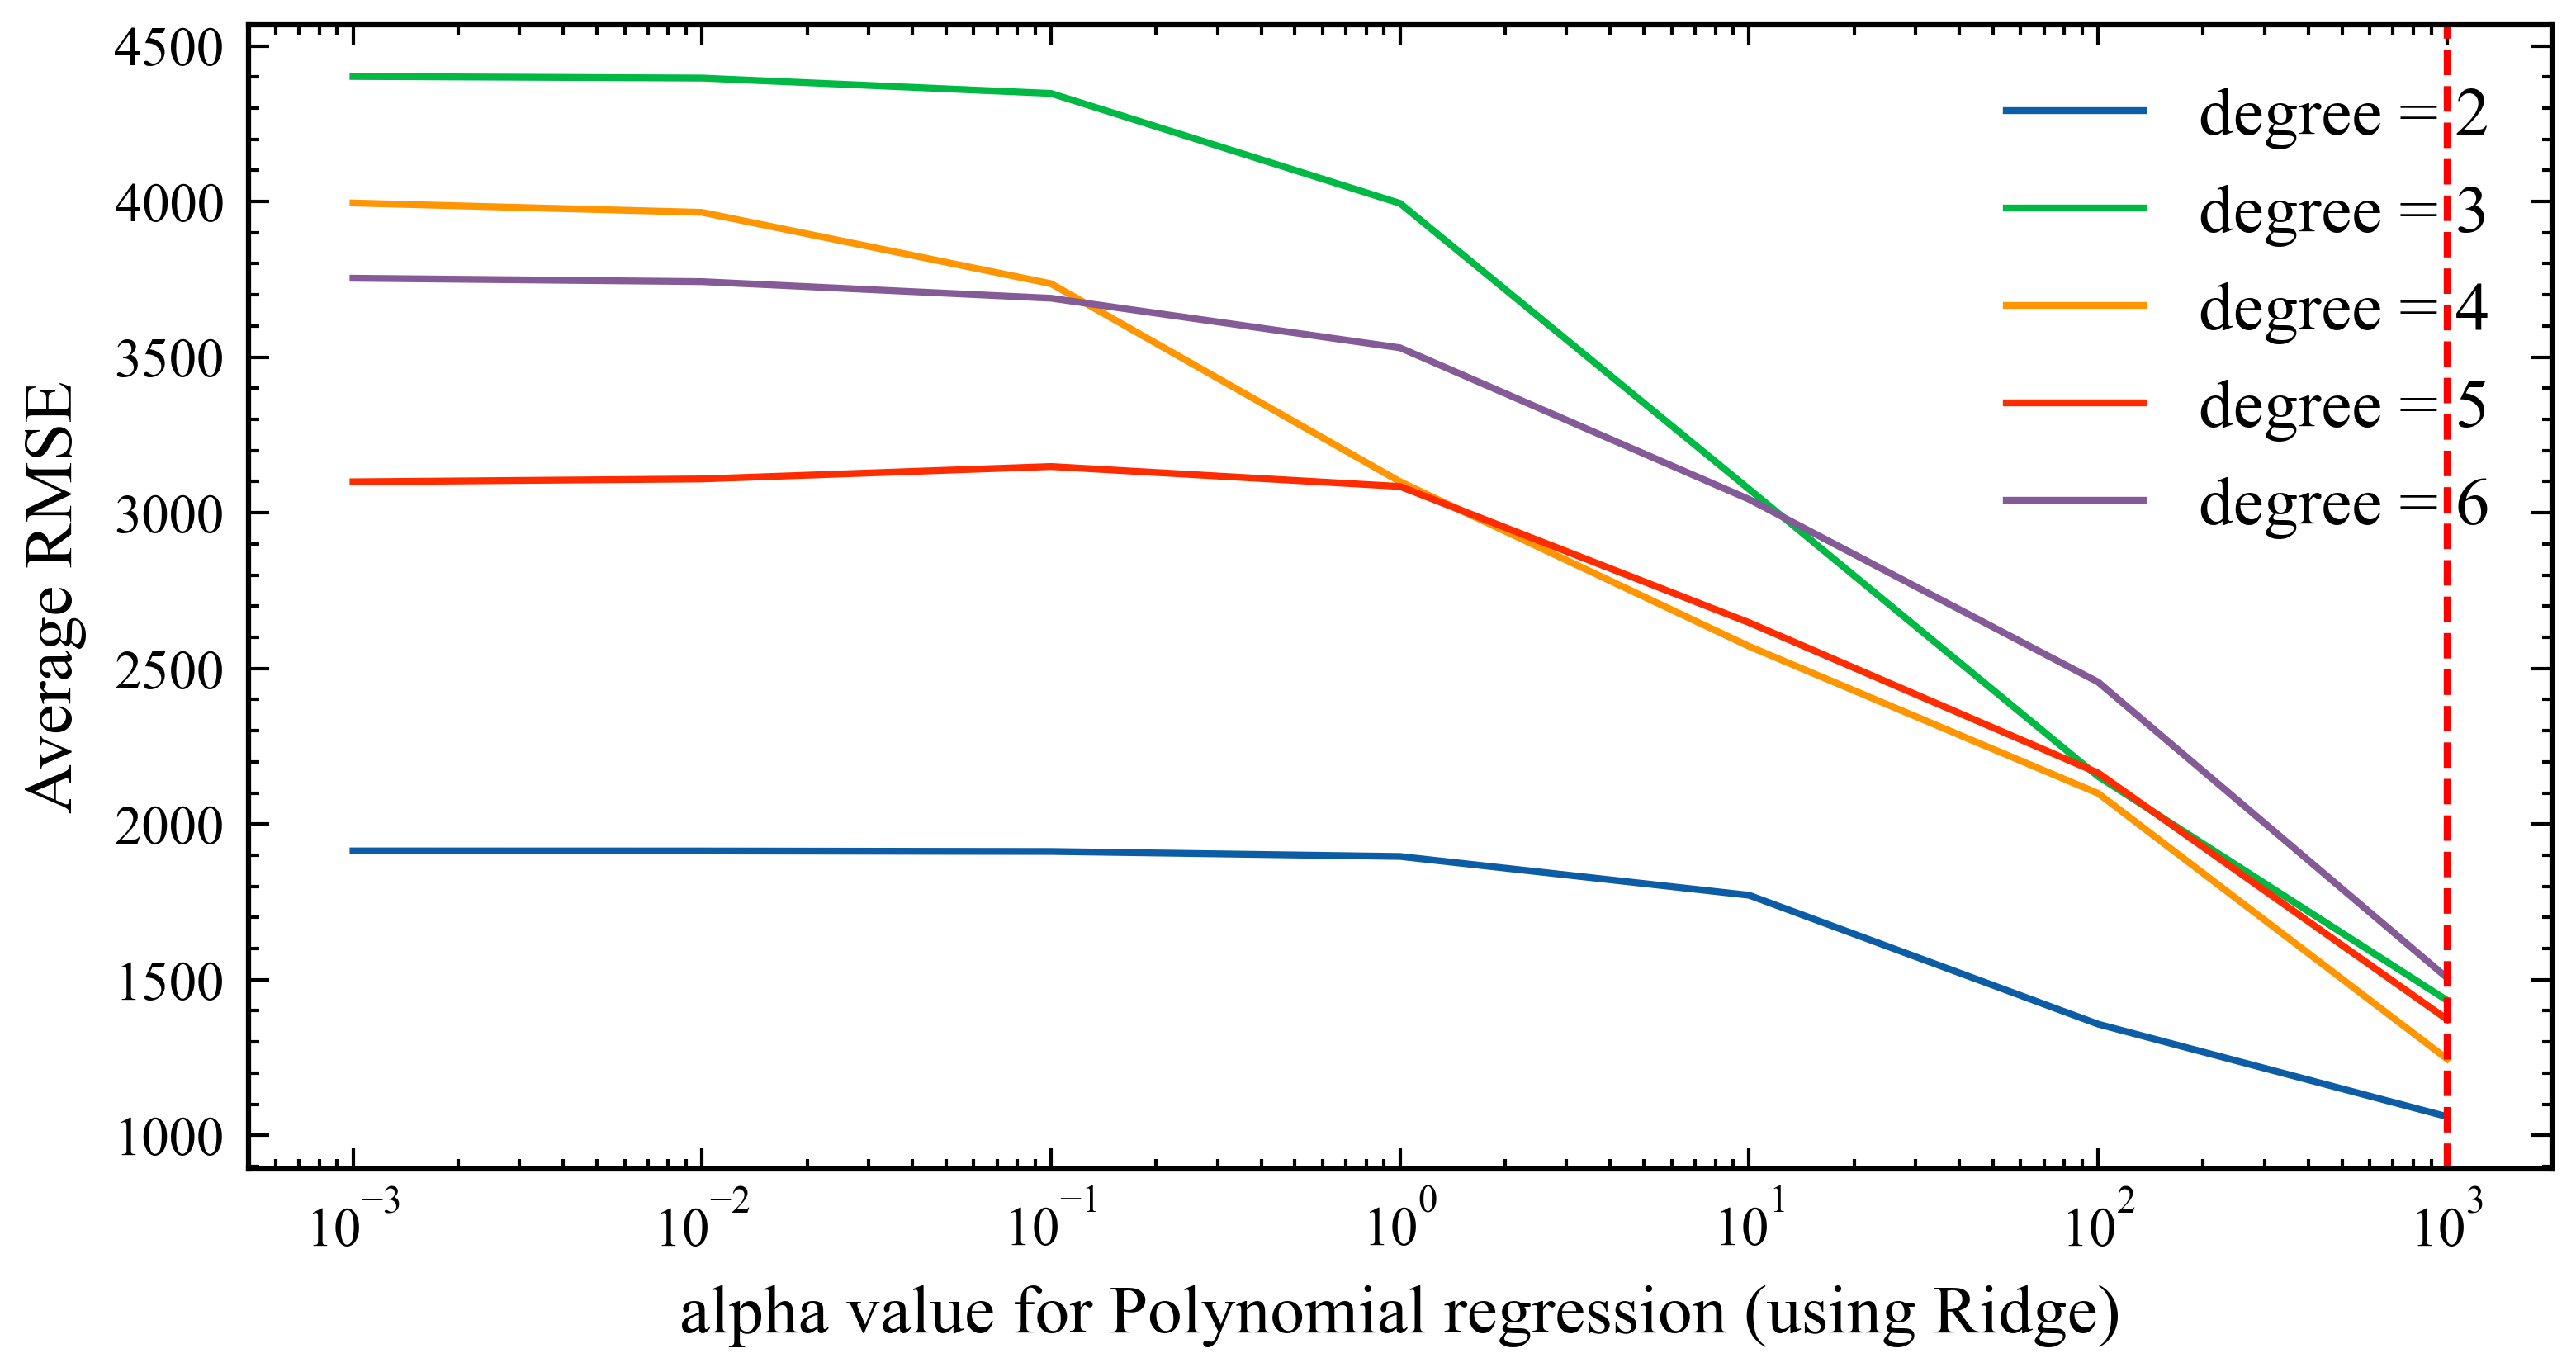

In [21]:
# plotting the Average RMSE for each alpha value on a log scale
plt.figure(figsize=(6, 3), dpi=300)
for i in range(len(errDegree)):
    plt.plot(alphas, errDegree[i], label=f'degree = {i + 2}')

plt.axvline(x=1000, color='red', linestyle='--')
#plt.text(alphas[np.argmin(errAlpha)] + 1, np.min(errAlpha) + 0.05, f'alpha = {alphas[np.argmin(errAlpha)]:.2f}')
plt.xscale('log')
plt.xlabel('alpha value for Polynomial regression (using Ridge)')
plt.ylabel('Average RMSE')
plt.xticks(size=8)
plt.yticks(size=8)
plt.legend()
plt.savefig('Q5_1.pdf', dpi=500, bbox_inches='tight')
plt.show()

In [23]:
# perform polynomial regression on the training set and use ridge regression on compound features
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
errors = []
ridgeReg = Ridge(alpha=1000.0)
for i, (train_index, val_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=42).split(X_train_poly, y_train)):
    ridgeReg.fit(X_train_poly[train_index], y_train[train_index])
    y_pred = ridgeReg.predict(X_train_poly[val_index])
    rmse = mean_squared_error(y_train[val_index], y_pred, squared=False)
    errors.append(rmse)
    print(f'Fold {i + 1} RMSE: {rmse:.4f}')

print('_' * 40)
print(f'Average RMSE\t: {np.mean(errors):.4f}')
y_pred = ridgeReg.predict(X_test_poly) # test the model on the testing set and print the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Test RMSE\t: {rmse:.4f}')

Fold 1 RMSE: 845.8599
Fold 2 RMSE: 798.1191
Fold 3 RMSE: 845.5023
Fold 4 RMSE: 963.9883
Fold 5 RMSE: 838.1119
Fold 6 RMSE: 965.2044
Fold 7 RMSE: 855.1974
Fold 8 RMSE: 861.7911
Fold 9 RMSE: 2756.9150
Fold 10 RMSE: 869.9334
________________________________________
Average RMSE	: 1060.0623
Test RMSE	: 849.8759


In [24]:
poly.powers_

array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 1],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 1]])

In [233]:
ridgeReg.coef_

array([   0.        ,  -22.78768779, -158.93458834,   42.78495309,
         30.30014498,    8.87912446,   -6.32799706,  258.68732739,
        724.07252917,  246.3717205 ,  112.39852203,    5.35398237,
        123.17087451,   -1.53624949,   86.90127827,   32.53051891,
       -122.08730452,   25.88053938,  -38.16481403,  422.28246207,
        280.49753831, -222.07713575])

In [28]:
rowNames = np.array(['carat', 'color', 'clarity', 'x', 'y', 'z'])

In [33]:
for i in range(poly.powers_.shape[0]):
    print(f'Features : {rowNames[poly.powers_[i]==1]} \t\t: {ridgeReg.coef_[i]:.5f}')

Features : [] 		: 0.00000
Features : ['carat'] 		: 1341.74780
Features : ['color'] 		: 535.65625
Features : ['clarity'] 		: 899.15907
Features : ['x'] 		: 1025.53771
Features : ['y'] 		: 900.85690
Features : ['z'] 		: 476.24326
Features : ['carat' 'color'] 		: 366.07723
Features : ['carat' 'clarity'] 		: 785.18252
Features : ['carat' 'x'] 		: 310.94712
Features : ['carat' 'y'] 		: 123.14961
Features : ['carat' 'z'] 		: -47.52488
Features : ['color' 'clarity'] 		: 322.29838
Features : ['color' 'x'] 		: 112.11461
Features : ['color' 'y'] 		: 206.64826
Features : ['color' 'z'] 		: -74.88745
Features : ['clarity' 'x'] 		: 9.95633
Features : ['clarity' 'y'] 		: 141.59831
Features : ['clarity' 'z'] 		: -13.21620
Features : ['x' 'y'] 		: 672.89407
Features : ['x' 'z'] 		: 601.26724
Features : ['y' 'z'] 		: -355.21911


In [ ]:
'''
3 : carat
2 : color
2 : clarity
3 : x
2 : y
2 : z
'''


'''
carat
x
y
clarity
carat, clarity
x, y
x, z
color
z
carat, color
~~~~~~~~~~~~~~~~~~
y, z
color, clarity
carat, x
color, y
clarity, y
'''

In [34]:
np.sort(ridgeReg.coef_)

array([-355.21911236,  -74.88744717,  -47.52488147,  -13.21619746,
          0.        ,    9.9563321 ,  112.11460648,  123.14960898,
        141.59830528,  206.64825534,  310.94712377,  322.29837746,
        366.07722985,  476.24325797,  535.65625146,  601.26723781,
        672.89406584,  785.18252278,  899.15906833,  900.85689577,
       1025.53770615, 1341.74780364])

## Question 6

In [ ]:
# use GridSearchCV to find the best hyperparameters
hyperParameters = {'hidden_layer_sizes': [(10, 10), (10, 20), (10,50), (20,10), (20,20), (20,50), (50,10), (50,20), (50,50), 
                                          (10, 20, 50), (20, 20, 50), (20, 50, 50), (50, 20, 20), (50, 20, 10)],
                   'activation': ['relu', 'identity'],
                   'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100]}

# perform grid search
gridSearch = GridSearchCV(MLPRegressor(max_iter=400, learning_rate_init=0.001, random_state=42), hyperParameters, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=5)
gridSearch.fit(X_train, y_train)

In [93]:
print(f'Best hyperparameters: {gridSearch.best_params_}')
print(f'Best estimator: {gridSearch.best_estimator_}')
print(f'Best score: {gridSearch.best_score_}')

Best hyperparameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50)}


In [108]:
gsResults = pd.DataFrame(gridSearch.cv_results_)
gsResults.sort_values(by='rank_test_score', inplace=True)

In [128]:
display(gsResults.head(10))

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
22      45.316301      0.189657         0.003090        0.001021   
36      46.251251      2.772082         0.002655        0.000508   
50      46.701046      3.824932         0.002567        0.000343   
64      46.478127      3.798381         0.002936        0.001221   
78      46.495456      3.997668         0.003541        0.002271   
8       46.384155      0.345115         0.003716        0.001203   
82      38.949247      5.625255         0.001922        0.000035   
26      41.358905      2.581493         0.002498        0.001561   
21      33.218531      0.191548         0.001660        0.000125   
49      34.074667      2.664003         0.001975        0.000954   

   param_activation param_alpha param_hidden_layer_sizes  \
22             relu       0.001                 (50, 50)   
36             relu        0.01                 (50, 50)   
50             relu         0.1                 (50, 50)   
64             relu         1.0                 (50, 50)   
78             relu          10                 (50, 50)   
8              relu      0.0001                 (50, 50)   
82             relu          10             (50, 20, 20)   
26             relu       0.001             (50, 20, 20)   
21             relu       0.001                 (50, 20)   
49             relu         0.1                 (50, 20)   

                                               params  split0_test_score  \
22  {'activation': 'relu', 'alpha': 0.001, 'hidden...     -337589.700789   
36  {'activation': 'relu', 'alpha': 0.01, 'hidden_...     -339303.549933   
50  {'activation': 'relu', 'alpha': 0.1, 'hidden_l...     -354775.475530   
64  {'activation': 'relu', 'alpha': 1.0, 'hidden_l...     -356106.646089   
78  {'activation': 'relu', 'alpha': 10, 'hidden_la...     -473794.038125   
8   {'activation': 'relu', 'alpha': 0.0001, 'hidde...     -345660.467196   
82  {'activation': 'relu', 'alpha': 10, 'hidden_la...     -628560.493887   
26  {'activation': 'relu', 'alpha': 0.001, 'hidden...     -450372.719324   
21  {'activation': 'relu', 'alpha': 0.001, 'hidden...     -465991.504225   
49  {'activation': 'relu', 'alpha': 0.1, 'hidden_l...     -426044.545937   

    split1_test_score  ...  split3_test_score  split4_test_score  \
22     -321065.628551  ...     -338059.546541      -9.260030e+05   
36     -315848.098651  ...     -335989.130931      -9.293894e+05   
50     -324862.413679  ...     -338018.799858      -9.261020e+05   
64     -327141.217308  ...     -340437.628569      -9.052980e+05   
78     -321911.808694  ...     -338827.880814      -8.158974e+05   
8      -316395.076154  ...     -334212.785364      -1.029213e+06   
82     -347705.395962  ...     -337455.273591      -7.068590e+05   
26     -354650.711637  ...     -322230.867495      -8.495904e+05   
21     -339905.869248  ...     -360959.912866      -6.322794e+05   
49     -351293.662794  ...     -355253.718095      -7.240805e+05   

    split5_test_score  split6_test_score  split7_test_score  \
22     -378110.291552     -384523.960194     -329051.552036   
36     -369284.715832     -393510.439177     -329315.849898   
50     -371163.413710     -386627.529982     -332295.657043   
64     -420030.871188     -409743.172170     -335231.420927   
78     -439904.777996     -403821.347989     -329298.659673   
8      -364744.387228     -403136.930489     -330607.276135   
82     -384572.967445     -406331.308871     -336322.445978   
26     -472330.497113     -377373.861296     -324747.678698   
21     -457660.615614     -461456.744724     -388756.171397   
49     -475404.075048     -458837.750749     -359794.300954   

    split8_test_score  split9_test_score  mean_test_score  std_test_score  \
22     -345417.482543     -339808.738695   -409926.104942   173784.609230   
36     -341610.366444     -345814.538656   -410827.998370   175025.246486   
50     -346475.539932     -341784.769231   -414231.332714   172785.141450   
64    

In [96]:
y_pred = gridSearch.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Test RMSE\t: {rmse:.4f}')

Test RMSE	: 580.4219


In [38]:
mlpp = MLPRegressor(hidden_layer_sizes = (50,50), activation='relu', alpha=0.001, max_iter=400, learning_rate_init=0.001, random_state=42)

mlpp.fit(X_train, y_train)
y_pred = mlpp.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Test RMSE\t: {rmse:.4f}')

Test RMSE	: 580.4219


In [39]:
y_tr = mlpp.predict(X_train)
rmse = mean_squared_error(y_train, y_tr, squared=False)
print(f'Train RMSE\t: {rmse:.4f}')

Train RMSE	: 587.6985


## Question 7

Explain how these hyper-parameters affect the overall performance. Describe if
and how each hyper-parameter results in a regularization effect during training.
Overall Grid Search

In [47]:
depths = [2,3,4,5,6,8,10,12,14]

trees = [100,400,700,1000,1300]

feat = [2,3,4,5,6]

errors = []

In [ ]:
# Grid search

for d in tqdm(depths):

    for t in trees:

        for f in feat:

            rf_reg = RandomForestRegressor(max_depth=d, random_state=42, n_estimators = t, max_features = f)
            fold_errors = []

            for i, (train_index, val_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=42).split(X_train, y_train)):

                rf_reg.fit(X_train[train_index], y_train[train_index])
                y_pred = rf_reg.predict(X_train[val_index])
                rmse = mean_squared_error(y_train[val_index], y_pred, squared=False)
                fold_errors.append(rmse)

            errors.append((np.mean(fold_errors),d,t,f))


min_error = sorted(errors, key=lambda x: x[0])[0]
print(f'Best RMSE:\t {min_error[0]:.4f}, Depth:\t {min_error[1]}, Num Trees:\t {min_error[2]}, Num Features:\t {min_error[3]}')

100%|█████████████████████████████████████████| 9/9 [8:54:35<00:00, 3563.98s/it]

Best RMSE:	 551.9184, Depth:	 14, Num Trees:	 1000, Num Features:	 4


In [49]:
d_errors = []
for d in tqdm(depths):
    rf_reg = RandomForestRegressor(max_depth=d, random_state=42, n_estimators = 1000, max_features = 4)
    fold_errors = []
    
    for i, (train_index, val_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=42).split(X_train, y_train)):

        rf_reg.fit(X_train[train_index], y_train[train_index])
        y_pred = rf_reg.predict(X_train[val_index])
        rmse = mean_squared_error(y_train[val_index], y_pred, squared=False)
        fold_errors.append(rmse)

    d_errors.append(np.mean(fold_errors))



100%|██████████| 9/9 [30:00<00:00, 200.07s/it]


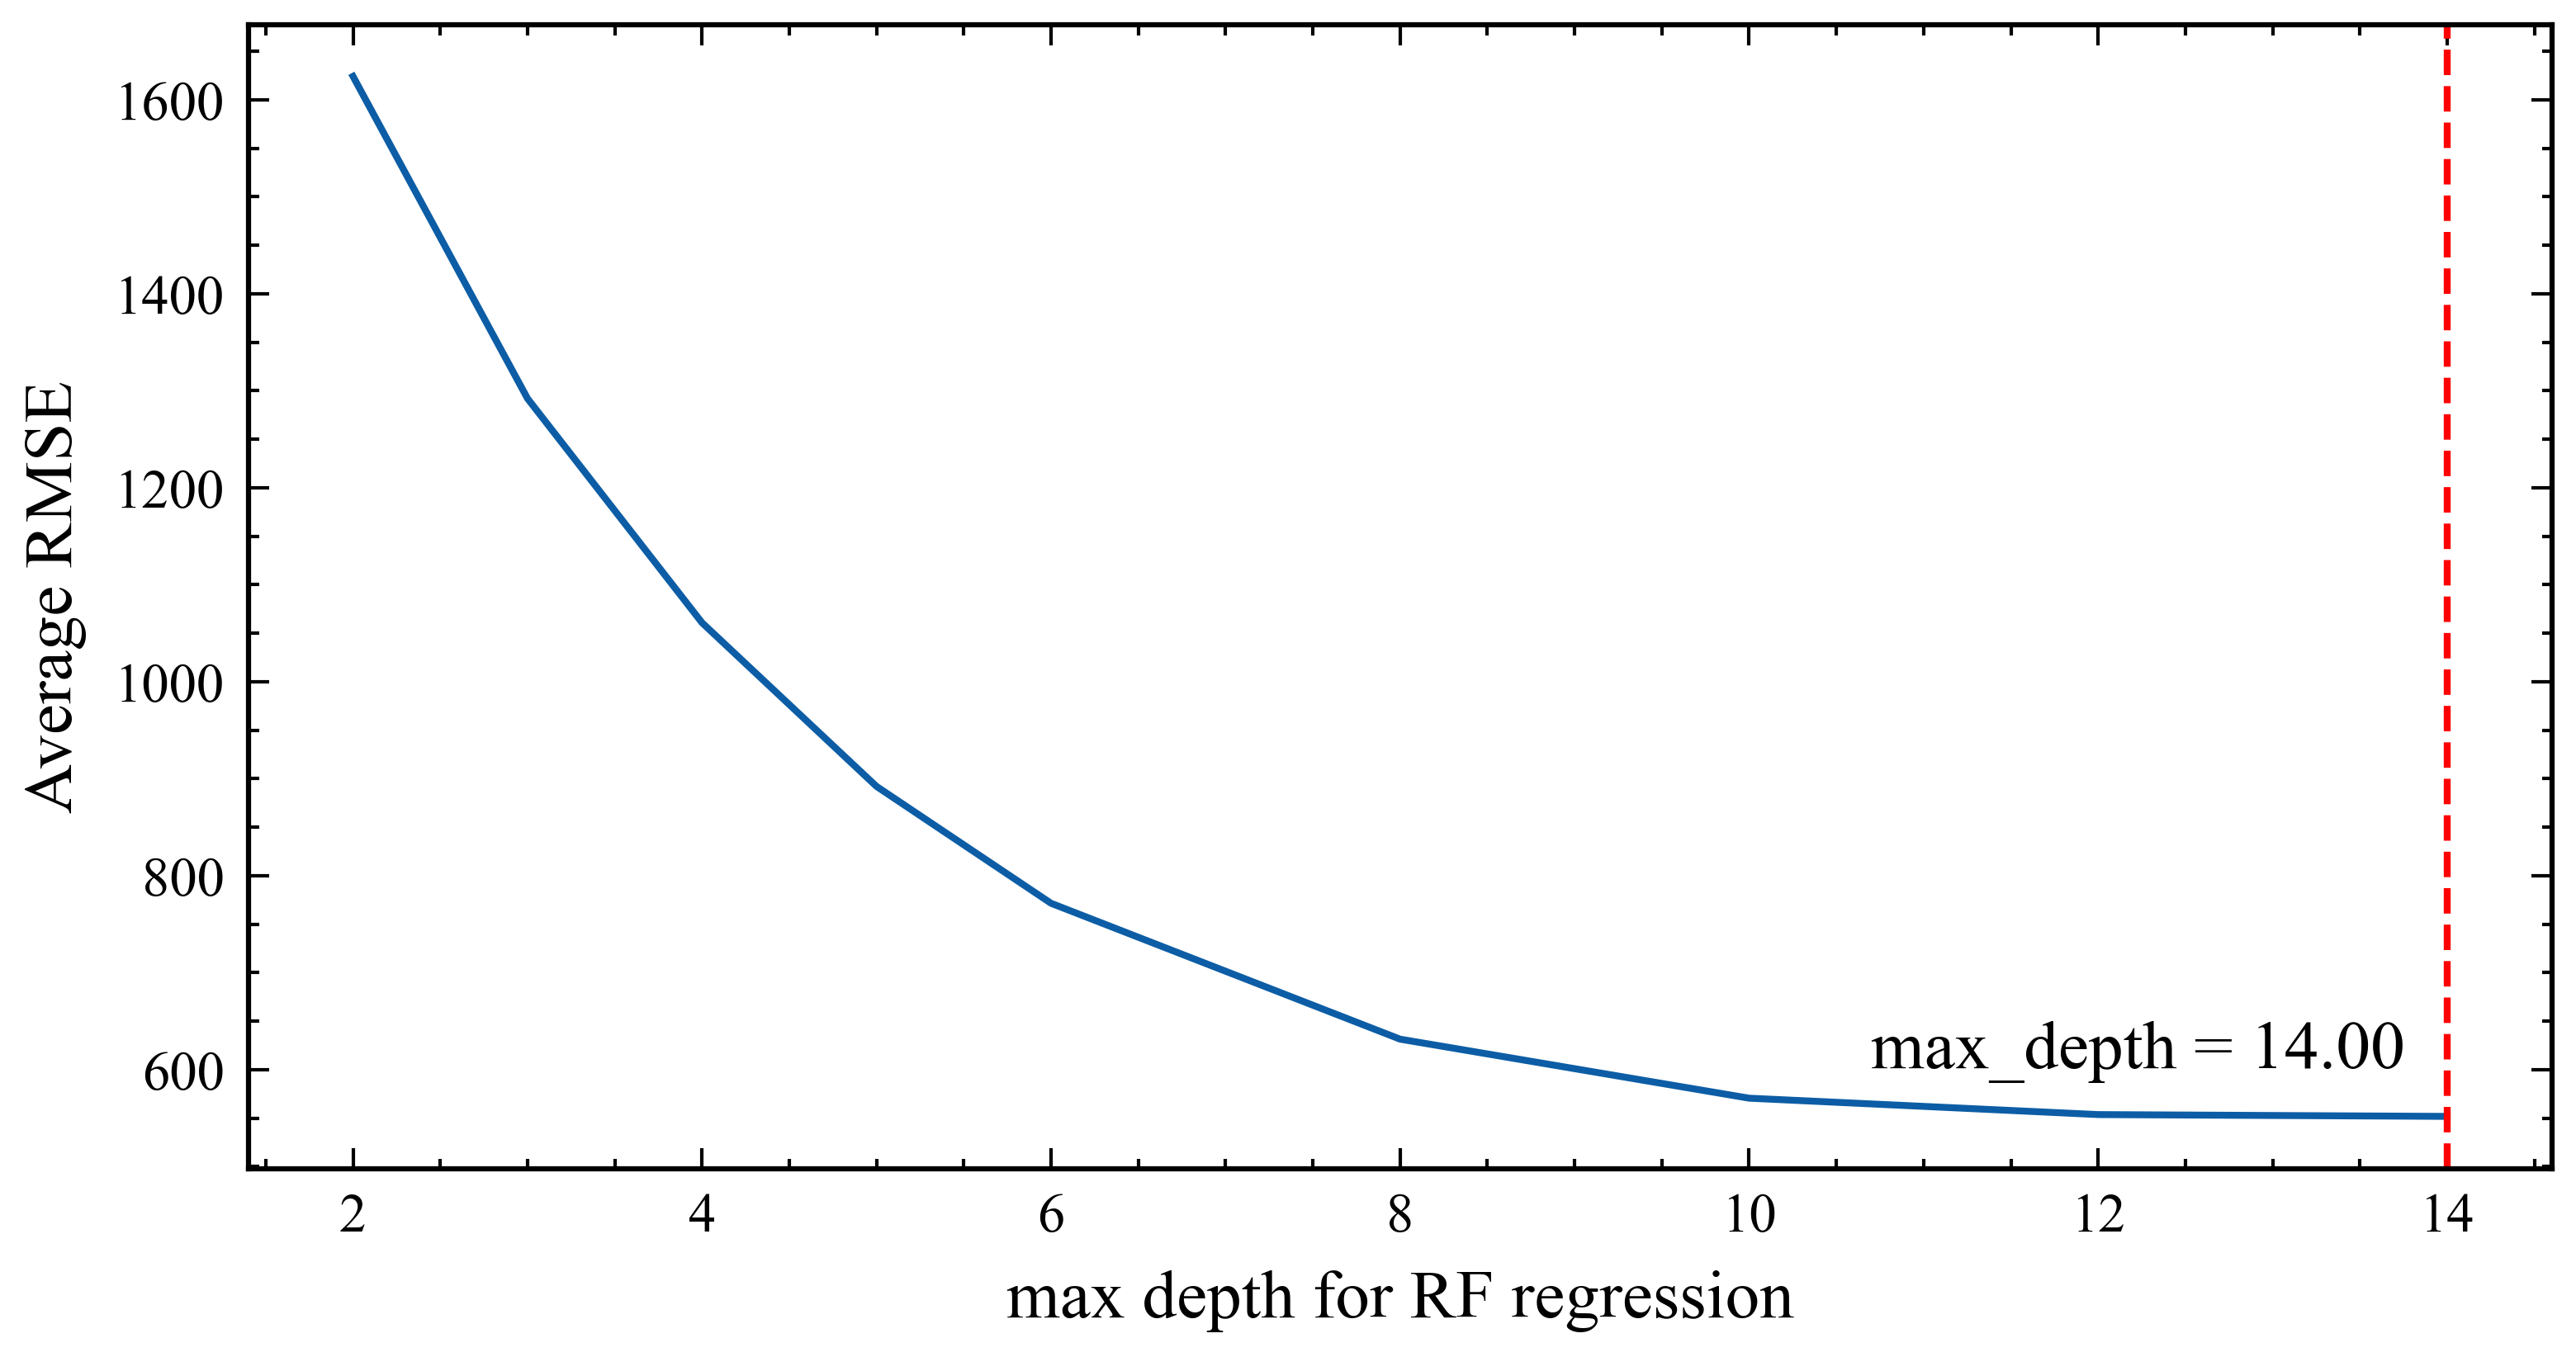

In [54]:
plt.figure(figsize=(6, 3), dpi=300)
plt.plot(depths, d_errors)
plt.axvline(x=depths[np.argmin(d_errors)], color='red', linestyle='--')
plt.text(depths[np.argmin(d_errors)] - 3.3, np.min(d_errors) + 50, f'max_depth = {depths[np.argmin(d_errors)]:.2f}')
# plt.xscale('log')
plt.xlabel('max depth for RF regression')
plt.ylabel('Average RMSE')
plt.xticks(size=8)
plt.yticks(size=8)
plt.savefig('Q7_1.pdf', dpi=500, bbox_inches='tight')
plt.show()

Effect of changing num_estimators

In [56]:
t_errors = []
for t in tqdm(trees):

    rf_reg = RandomForestRegressor(max_depth=14, random_state=42, n_estimators = t, max_features = 4)
    fold_errors = []

    for i, (train_index, val_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=42).split(X_train, y_train)):

        rf_reg.fit(X_train[train_index], y_train[train_index])
        y_pred = rf_reg.predict(X_train[val_index])
        rmse = mean_squared_error(y_train[val_index], y_pred, squared=False)
        fold_errors.append(rmse)

    t_errors.append(np.mean(fold_errors))

100%|██████████| 5/5 [21:47<00:00, 261.60s/it]


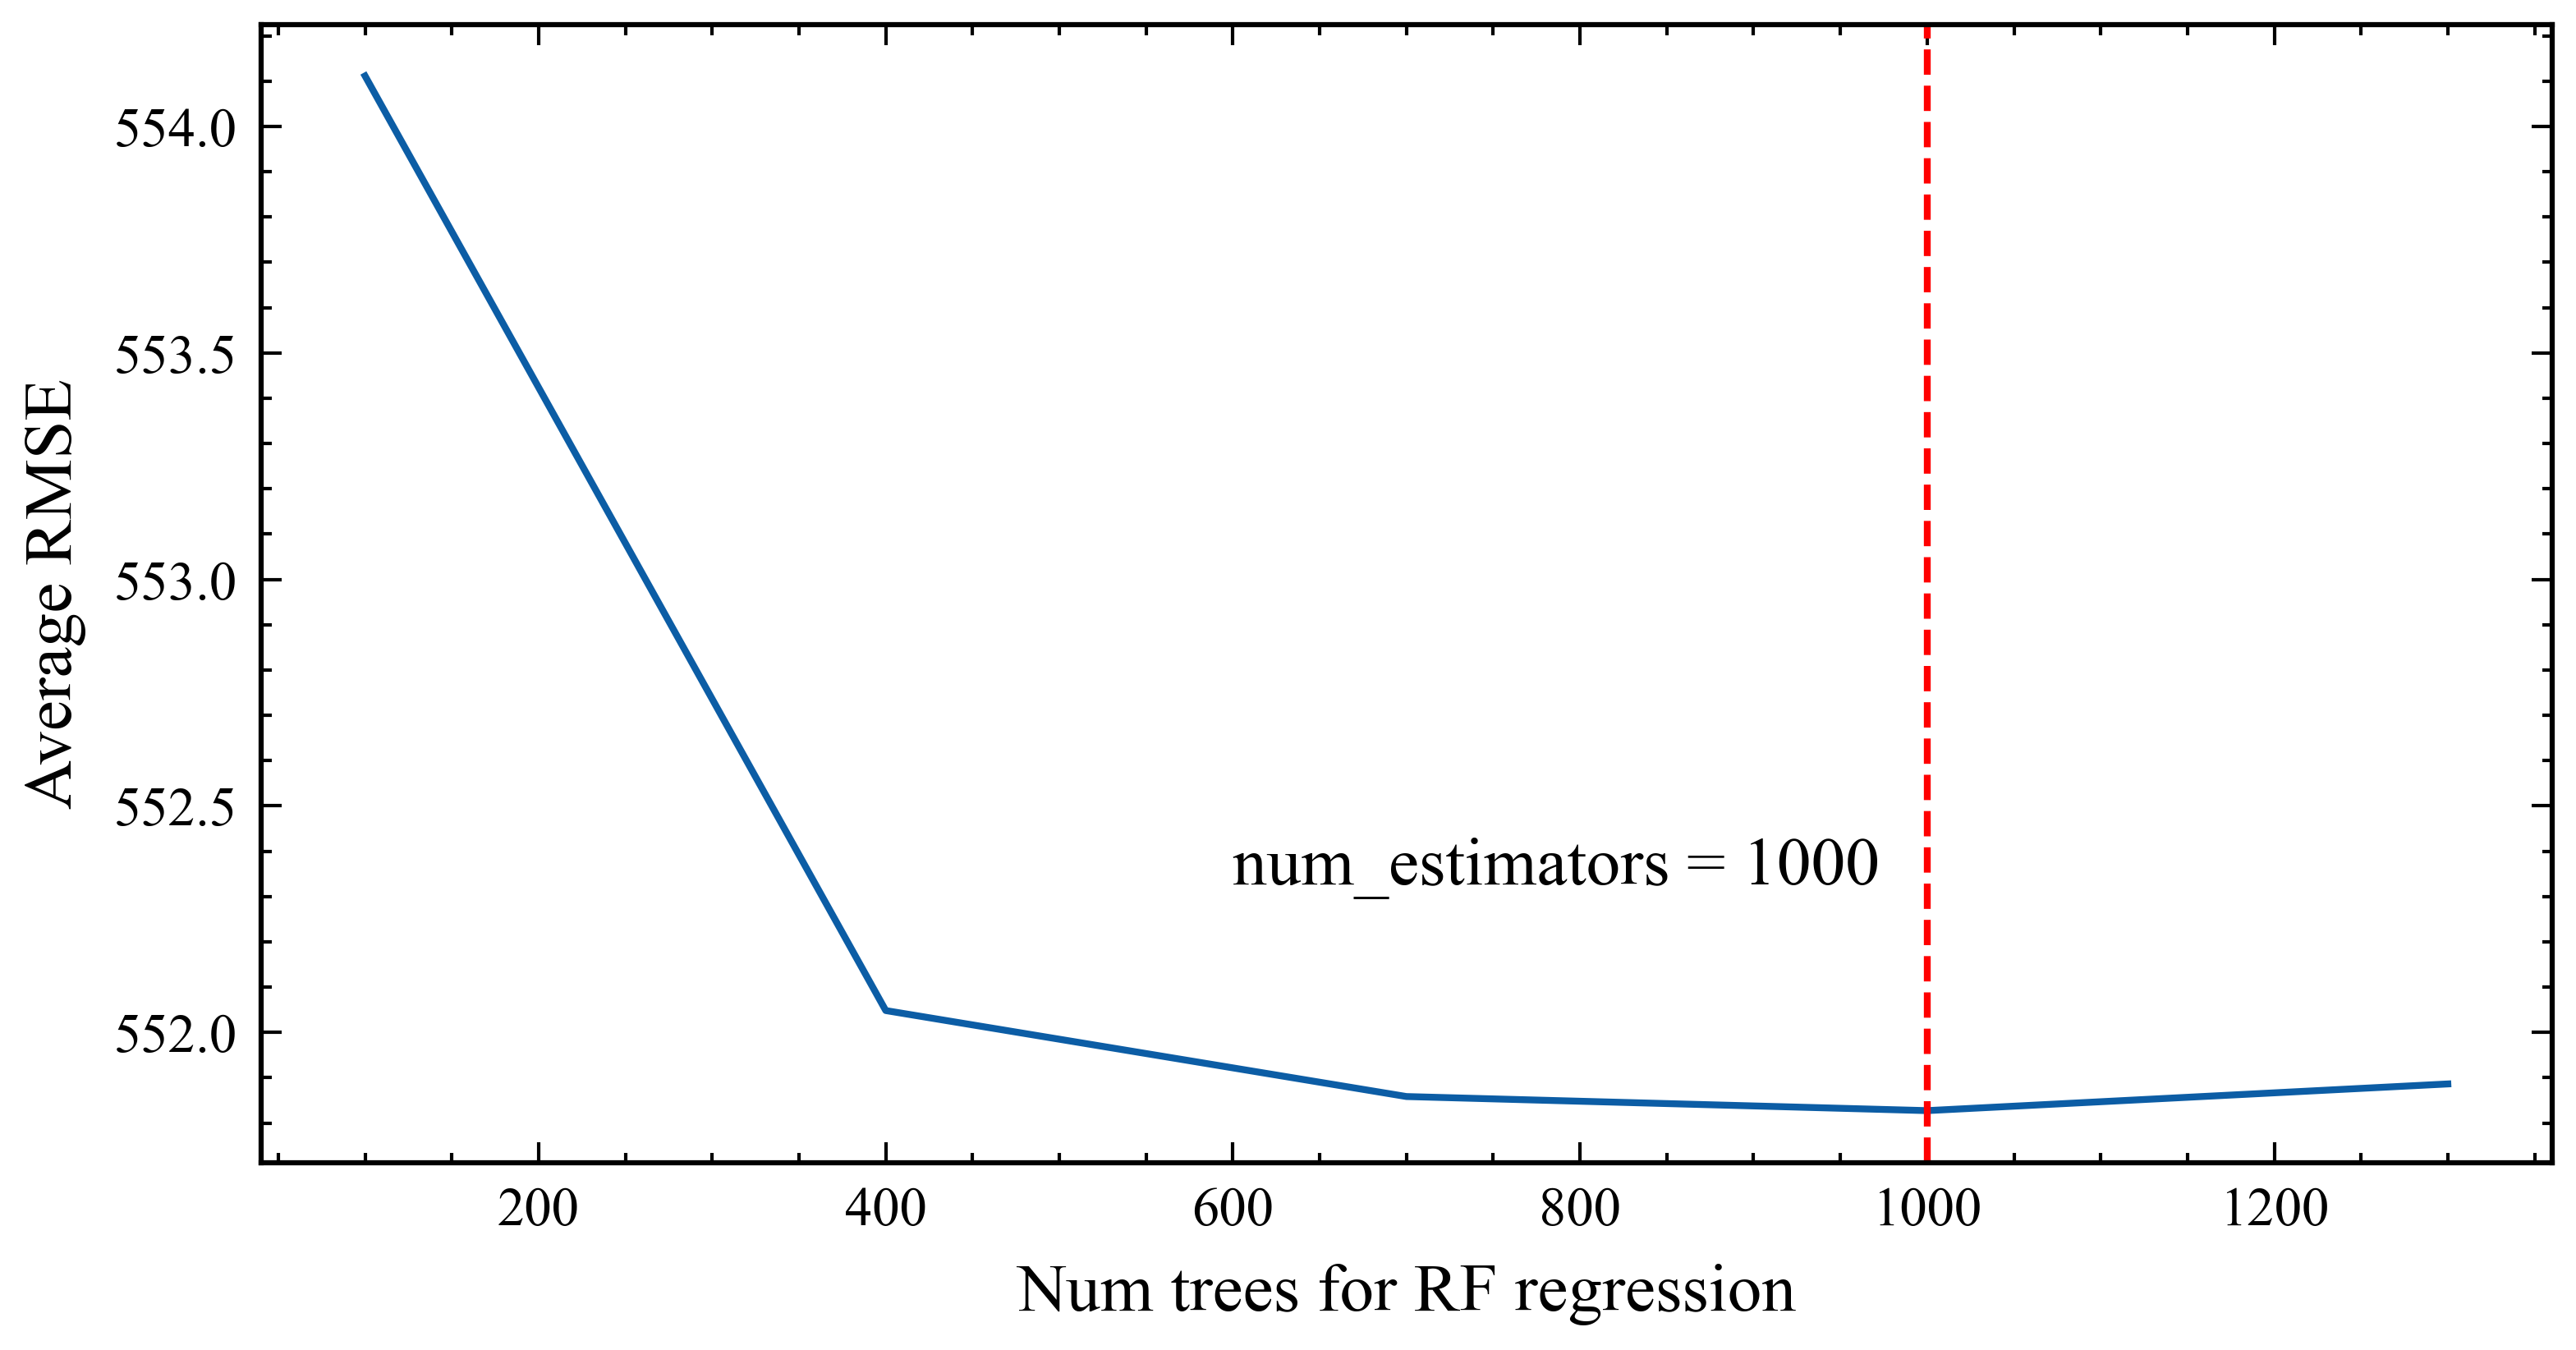

In [63]:
plt.figure(figsize=(6, 3), dpi=300)
plt.plot(trees, t_errors)
plt.axvline(x=trees[np.argmin(t_errors)], color='red', linestyle='--')
plt.text(trees[np.argmin(t_errors)] - 400, np.min(t_errors) + 0.5, f'num_estimators = {trees[np.argmin(t_errors)]:.0f}')
# plt.xscale('log')
plt.xlabel('Num trees for RF regression')
plt.ylabel('Average RMSE')
plt.xticks(size=8)
plt.yticks(size=8)
plt.savefig('Q7_2.pdf', dpi=500, bbox_inches='tight')
plt.show()

Effect of changing num_features

In [105]:
f_errors = []
for f in tqdm(feat):

    rf_reg = RandomForestRegressor(max_depth=14, random_state=42, n_estimators = 1000, max_features = f)
    fold_errors = []

    for i, (train_index, val_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=42).split(X_train, y_train)):

        rf_reg.fit(X_train[train_index], y_train[train_index])
        y_pred = rf_reg.predict(X_train[val_index])
        rmse = mean_squared_error(y_train[val_index], y_pred, squared=False)
        fold_errors.append(rmse)

    f_errors.append(np.mean(fold_errors))
    print(f_errors)

 20%|██        | 1/5 [03:35<14:22, 215.51s/it]

[567.4970224174036]


 40%|████      | 2/5 [08:28<13:03, 261.16s/it]

[567.4970224174036, 553.3521194760008]


 60%|██████    | 3/5 [14:40<10:23, 311.68s/it]

[567.4970224174036, 553.3521194760008, 551.8274756053477]


 80%|████████  | 4/5 [22:03<06:03, 363.48s/it]

[567.4970224174036, 553.3521194760008, 551.8274756053477, 552.8115557729452]


100%|██████████| 5/5 [30:39<00:00, 368.00s/it]

[567.4970224174036, 553.3521194760008, 551.8274756053477, 552.8115557729452, 555.4620729980464]


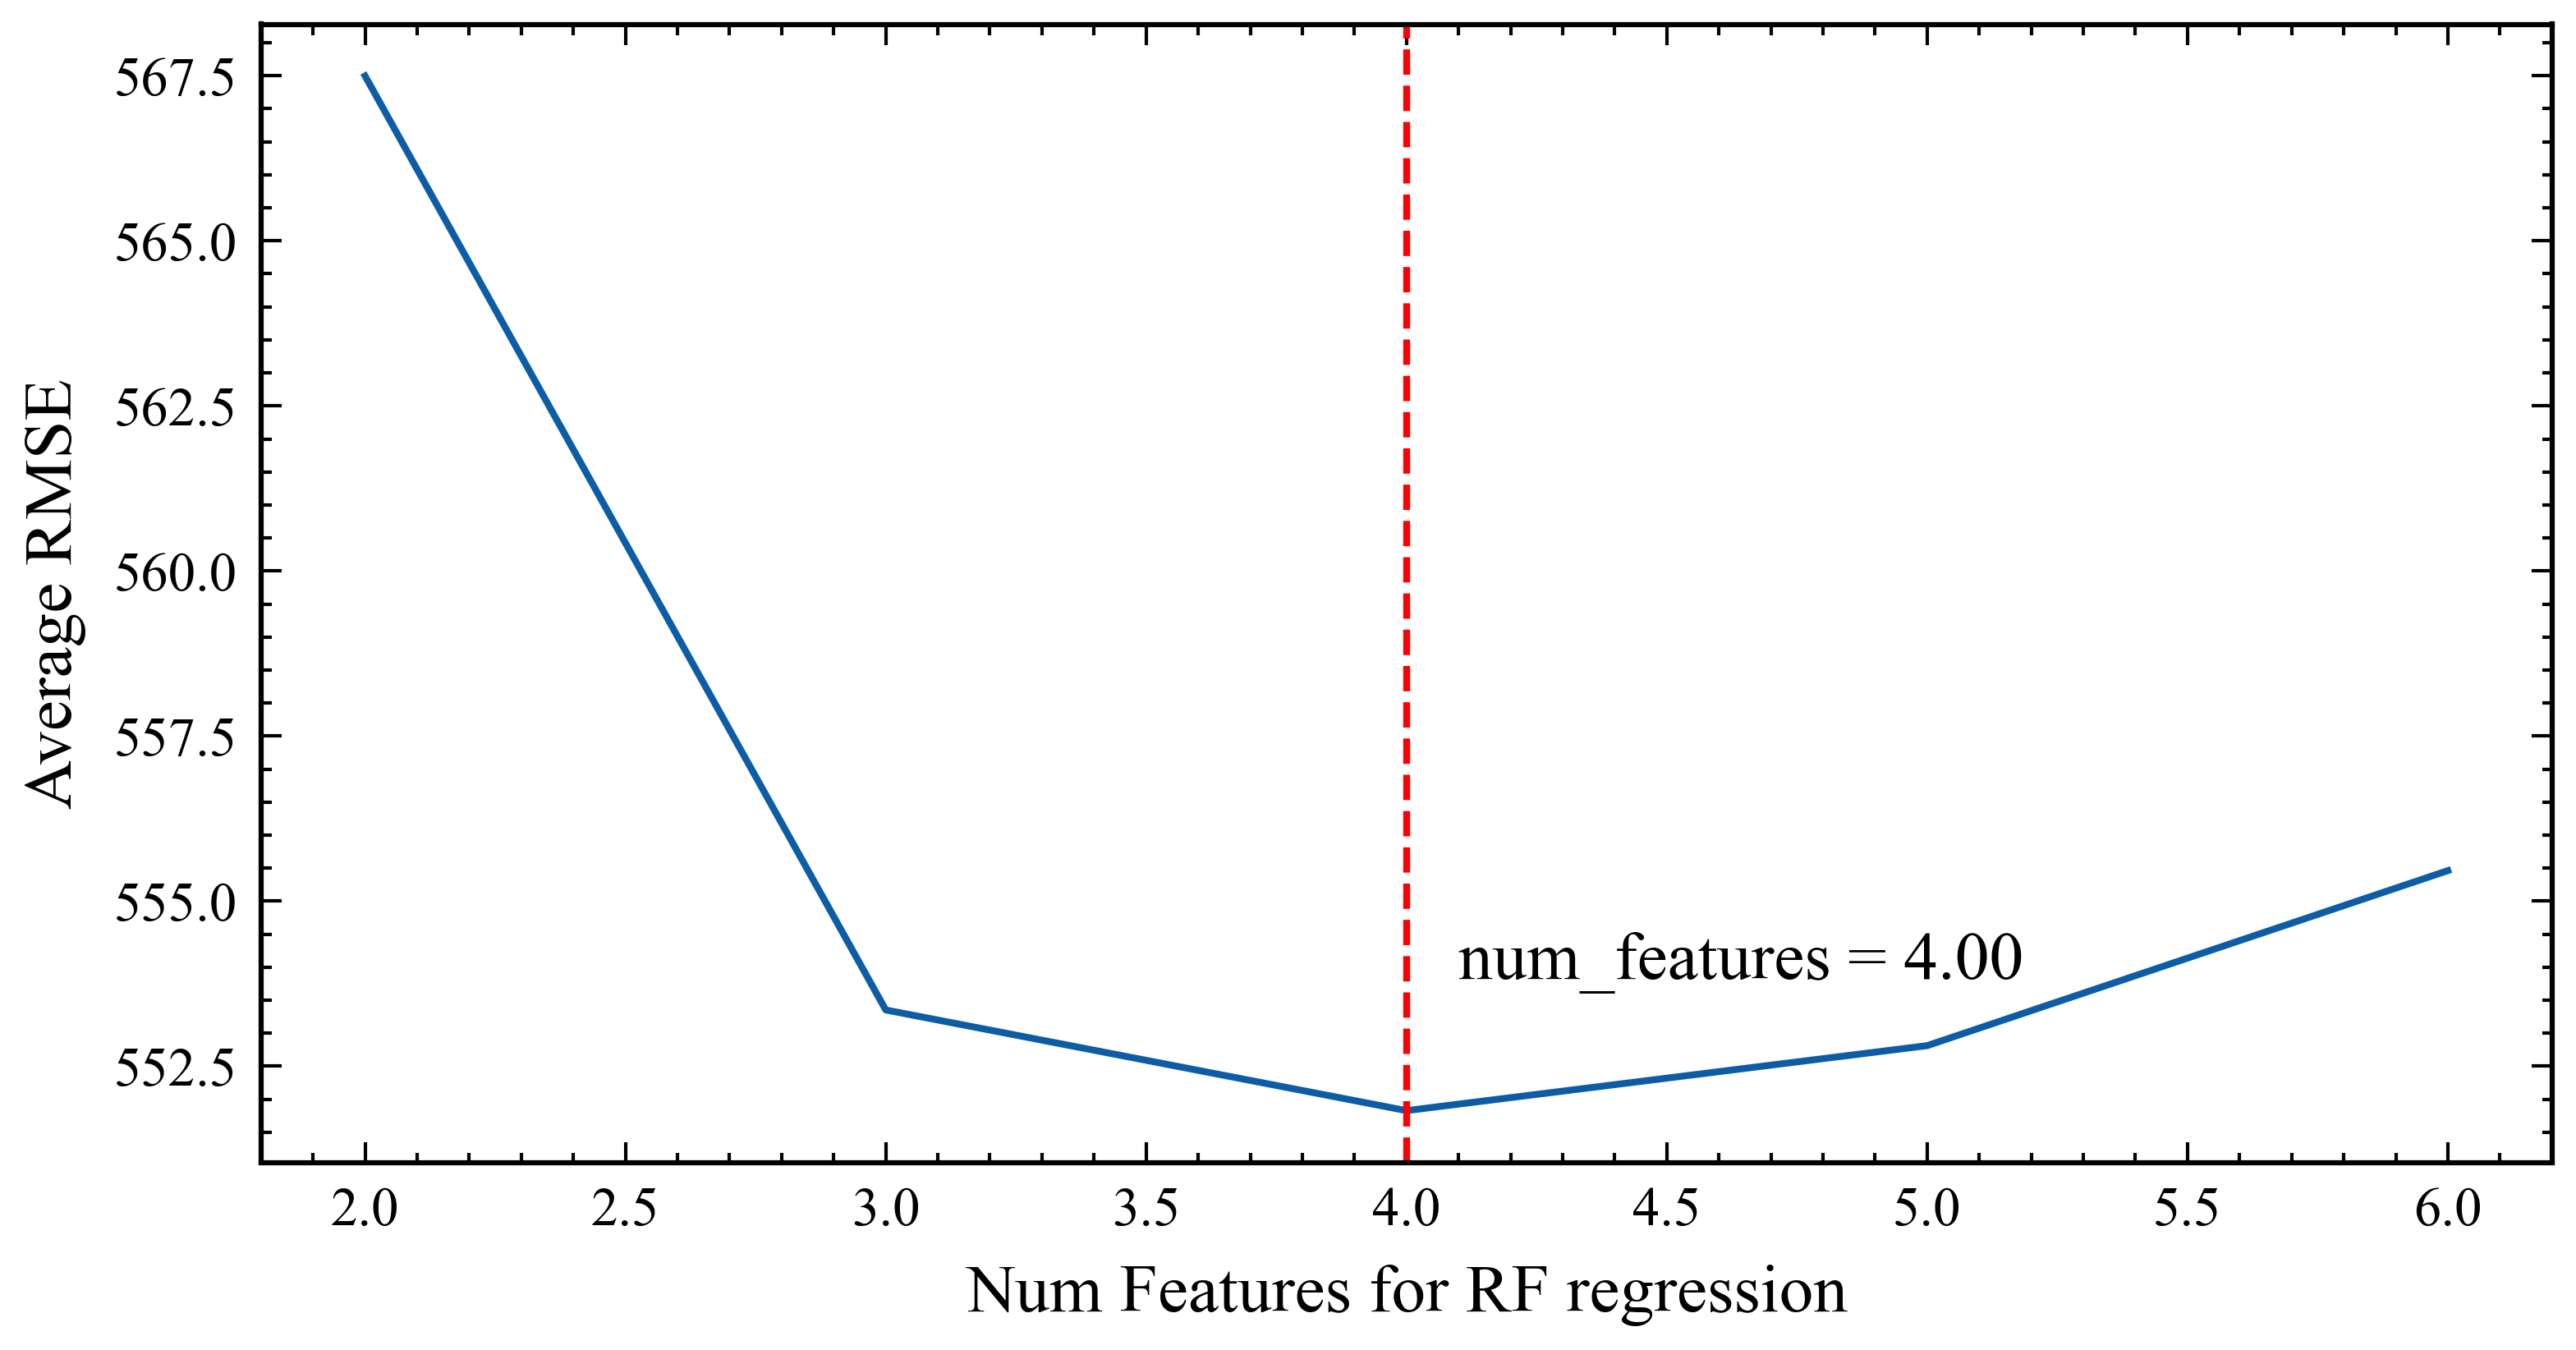

In [108]:
plt.figure(figsize=(6, 3), dpi=300)
plt.plot(feat, f_errors)
plt.axvline(x=feat[np.argmin(f_errors)], color='red', linestyle='--')
plt.text(feat[np.argmin(f_errors)] + 0.1, np.min(f_errors) + 2, f'num_features = {feat[np.argmin(f_errors)]:.2f}')
# plt.xscale('log')
plt.xlabel('Num Features for RF regression')
plt.ylabel('Average RMSE')
plt.xticks(size=8)
plt.yticks(size=8)
plt.savefig('Q7_3.pdf', dpi=500, bbox_inches='tight')
plt.show()

Effect of each hyperparameter:

1. max_depth: This controls the overall complexity of the model. By increasing the max depth we can model more complicated relationships between variables, but this might result in overfitting

2. num_features: limits the max number of features selected in a single tree (estimator) in the random forest. Increasing this number helps model more complicated relationships, but might cause overfitting

3. num_estimators: By increasing the number of estimators used in the model, we prevent overfitting by increasing the generalization of the overall model. Thus it has a regularization effect

### Q 7.2

How do random forests create a highly non-linear decision boundary despite the fact that all we do at each layer is apply a threshold on a feature? 

The process of selection of a variable by applying a threshold is itself a non linear process, as essentially a 'decision' is made on the subsequent path to follow. If this relationship is potted for just two variables x,y we would see a discontinuity in the derivative of y wrt x, essentially signalling the non linear relationship.

In a random forest we repeat this prcoees several times for each individual tree, and we have an entire ensemble of trees. Thus the overall decision boundary ends up have a lot of dicontinuities, and is thus highly non linear

### Q 7.3

Randomly pick a tree in your random forest model (with maximum depth of 4) and
plot its structure. Which feature is selected for branching at the root node? What can you infer about the importance of this feature as opposed to others? Do the important features correspond to what you got in part 3.3.1? 

In [96]:
rf_reg = RandomForestRegressor(max_depth=4, random_state=42, n_estimators = 1000, max_features = 4, oob_score=True)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, max_features=4, n_estimators=1000,
                      oob_score=True, random_state=42)

In [104]:
plt.figure(figsize=(20, 15), dpi=300)
plot_tree(rf_reg.estimators_[0], 
          feature_names=['carat', 'color', 'clarity', 'x', 'y', 'z'],
          class_names="price", 
          filled=True, impurity=True, 
          rounded=True, fontsize=10, precision=2)
plt.savefig('Q7_4.pdf', dpi=500, bbox_inches='tight')
plt.show()

Feature selected at root node: Carat.

Thus we can infer that among all the features in the dataset, this is the feature with the greatest impact on the price of a given diamond

In general as we go further dwon the tree, we observe that the features seem to be present in terms of the predictive power they have on the y variable price.

(Need to add content on comparison with 3.3.1)

### Q 7.4

Measure “Out-of-Bag Error” (OOB). Explain what OOB error and R2 score means.

In [ ]:
rf_reg = RandomForestRegressor(max_depth=min_error[1], random_state=42, n_estimators = min_error[2], max_features = min_error[3], oob_score=True)
errors = []
scores = []
oobs = []
for i, (train_index, val_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=42).split(X_train, y_train)):
    rf_reg.fit(X_train[train_index], y_train[train_index])
    y_pred = rf_reg.predict(X_train[val_index])
    rmse = mean_squared_error(y_train[val_index], y_pred, squared=False)
    score = rf_reg.score(X_train[val_index], y_train[val_index])
    oob = 1 - rf_reg.oob_score_
    errors.append(rmse)
    scores.append(score)
    oobs.append(oob)
    print(f'Fold {i + 1} RMSE: {rmse:.4f}, R2 Score: {score:.4f}, OOB Error : {oob:.4f}')


print('_' * 40)
print(f'Average RMSE\t: {np.mean(errors):.4f}')
print(f'Average R2 Score\t: {np.mean(scores):.4f}')
print(f'Average OOB Error\t: {np.mean(oobs):.4f}')
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test) # test the model on the testing set and print the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
score = rf_reg.score(X_train[val_index], y_train[val_index])
oob = 1 - rf_reg.oob_score_
print(f'Test RMSE\t: {rmse:.4f}')
print(f'Test R2 Score\t: {score:.4f}')
print(f'Test OOB Error\t: {oob:.4f}')

Fold 1 RMSE: 557.9284, R2 Score: 0.9800, OOB Error : 0.0191
Fold 2 RMSE: 535.2826, R2 Score: 0.9820, OOB Error : 0.0193
Fold 3 RMSE: 556.1919, R2 Score: 0.9798, OOB Error : 0.0188
Fold 4 RMSE: 545.9637, R2 Score: 0.9812, OOB Error : 0.0191
Fold 5 RMSE: 561.3145, R2 Score: 0.9810, OOB Error : 0.0192
Fold 6 RMSE: 560.7316, R2 Score: 0.9796, OOB Error : 0.0190
Fold 7 RMSE: 542.0821, R2 Score: 0.9821, OOB Error : 0.0195
Fold 8 RMSE: 544.4877, R2 Score: 0.9816, OOB Error : 0.0190
Fold 9 RMSE: 569.0974, R2 Score: 0.9798, OOB Error : 0.0190
Fold 10 RMSE: 546.1045, R2 Score: 0.9814, OOB Error : 0.0190
________________________________________
Average RMSE	: 551.9184
Average R2 Score	: 0.9808
Average OOB Error	: 0.0191
Test RMSE	: 541.1832
Test R2 Score	: 0.9926
Test OOB Error	: 0.0189


## Question 8

### Q 8.1

Read the documentation of LightGBM OR CatBoost and determine the important
hyperparameters along with a search space for the tuning of these parameters (keep the search space small)

Chosen model: LightGBM

Important parameters for tuning LightGBM:

1. num_leaves: This parameter determines the overall complexity of the model as it essentially determines the number of final decision nodes each estimator has. A high value for num_leaves could cause overfitting

2. subsample: specifies the percentage of samples used per tree building iteration. By forcefully omitting some of the train set from some of the trees, we improve generalization of the model as it has a regularization effect. (This is analogous to dropout in Neural Networks)

3. max_depth: determines the max depth of an individual estimator. Having a large value leads to more complex models, but also can lead to overfitting and longer time to fit the model.

4. n_estimators: number of boosted trees to fit. Increasing this increases model complexity. However increasing this also leads to slower fitting of the model

5. reg_lambda: controls L2 regularization on the weights of the model to combat overfitting



### Q 8.2

Apply Bayesian optimization using skopt.BayesSearchCV from scikit-optmize
to find the ideal hyperparameter combination in your search space. Report the best hyperparameter set found and the corresponding RMSE.

In [ ]:
params = {
    'num_leaves': np.arange(2,1000,100),
    'n_estimators': np.arange(1,500,50),
    'subsample': np.arange(0.1,1,0.1),
    'max_depth': np.arange(1,10,1),
    'reg_lambda': np.arange(1,100,10)
}

clf = lgb.LGBMRegressor(random_state=42)

search = BayesSearchCV(clf, params, n_iter = 10, cv = 10,scoring = 'neg_root_mean_squared_error',return_train_score = True)

search.fit(X_train, y_train)

print("Best set of params")
print(search.best_params_)
print('Best RMSE:', -1*search.best_score_)

In [139]:
clf = lgb.LGBMRegressor(random_state=42, max_depth=search.best_params_['max_depth'], 
                        num_leaves = search.best_params_['num_leaves'], n_estimators = search.best_params_['n_estimators'], 
                        subsample = search.best_params_['subsample'], reg_lambda = search.best_params_['reg_lambda'])
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test) # test the model on the testing set and print the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
score = clf.score(X_test, y_test)
print(f'Test RMSE\t: {rmse:.4f}')
print(f'Test R2 Score\t: {score:.4f}')

Test RMSE	: 543.8293
Test R2 Score	: 0.9814


### Q 8.3 

Qualitatively interpret the effect of the hyperparameters using the Bayesian optimization results: Which of them helps with performance? Which helps with regularization (shrinks the generalization gap)? Which affects the fitting efficiency?

In [143]:
# params = {
#     'num_leaves': np.arange(2,1000,100),
#     'n_estimators': np.arange(1,500,50),
#     'subsample': np.arange(0.1,1,0.1),
#     'max_depth': np.arange(1,10,1),
#     'reg_lambda': np.arange(1,100,10)
# }

leaves = sorted(search.cv_results_['param_num_leaves'])
scores = []
for l in leaves:
    scores.append(-1*np.mean([search.cv_results_['mean_train_score'][k] 
                                for k in [i for i, x in enumerate(search.cv_results_['param_num_leaves']) 
                                          if x == l]])) 
    
plt.figure(figsize=(6, 3), dpi=300)    
plt.plot(leaves,scores)
plt.axvline(x=leaves[np.argmin(scores)], color='red', linestyle='--')
plt.text(leaves[np.argmin(scores)] + 15, np.min(scores) + 30, f'num_leaves = {leaves[np.argmin(scores)]:.0f}')
plt.xlabel('Num Leaves')
plt.ylabel('RMSE on val from 10 folds CV')
plt.xticks(size=8)
plt.yticks(size=8)
plt.savefig('Q8_1.pdf', dpi=500, bbox_inches='tight')
plt.show()

In [147]:
estimators = sorted(search.cv_results_['param_n_estimators'])
scores = []
for e in estimators:
    scores.append(-1*np.mean([search.cv_results_['mean_train_score'][k] 
                                for k in [i for i, x in enumerate(search.cv_results_['param_n_estimators']) 
                                          if x == e]])) 
    
plt.figure(figsize=(6, 3), dpi=300)    
plt.plot(estimators,scores)
plt.axvline(x=estimators[np.argmin(scores)], color='red', linestyle='--')
plt.text(estimators[np.argmin(scores)] -55 , np.min(scores) + 100, f'num_estimators = {estimators[np.argmin(scores)]:.0f}')
plt.xlabel('Num Estimators')
plt.ylabel('RMSE on val from 10 folds CV')
plt.xticks(size=8)
plt.yticks(size=8)
plt.savefig('Q8_2.pdf', dpi=500, bbox_inches='tight')
plt.show()

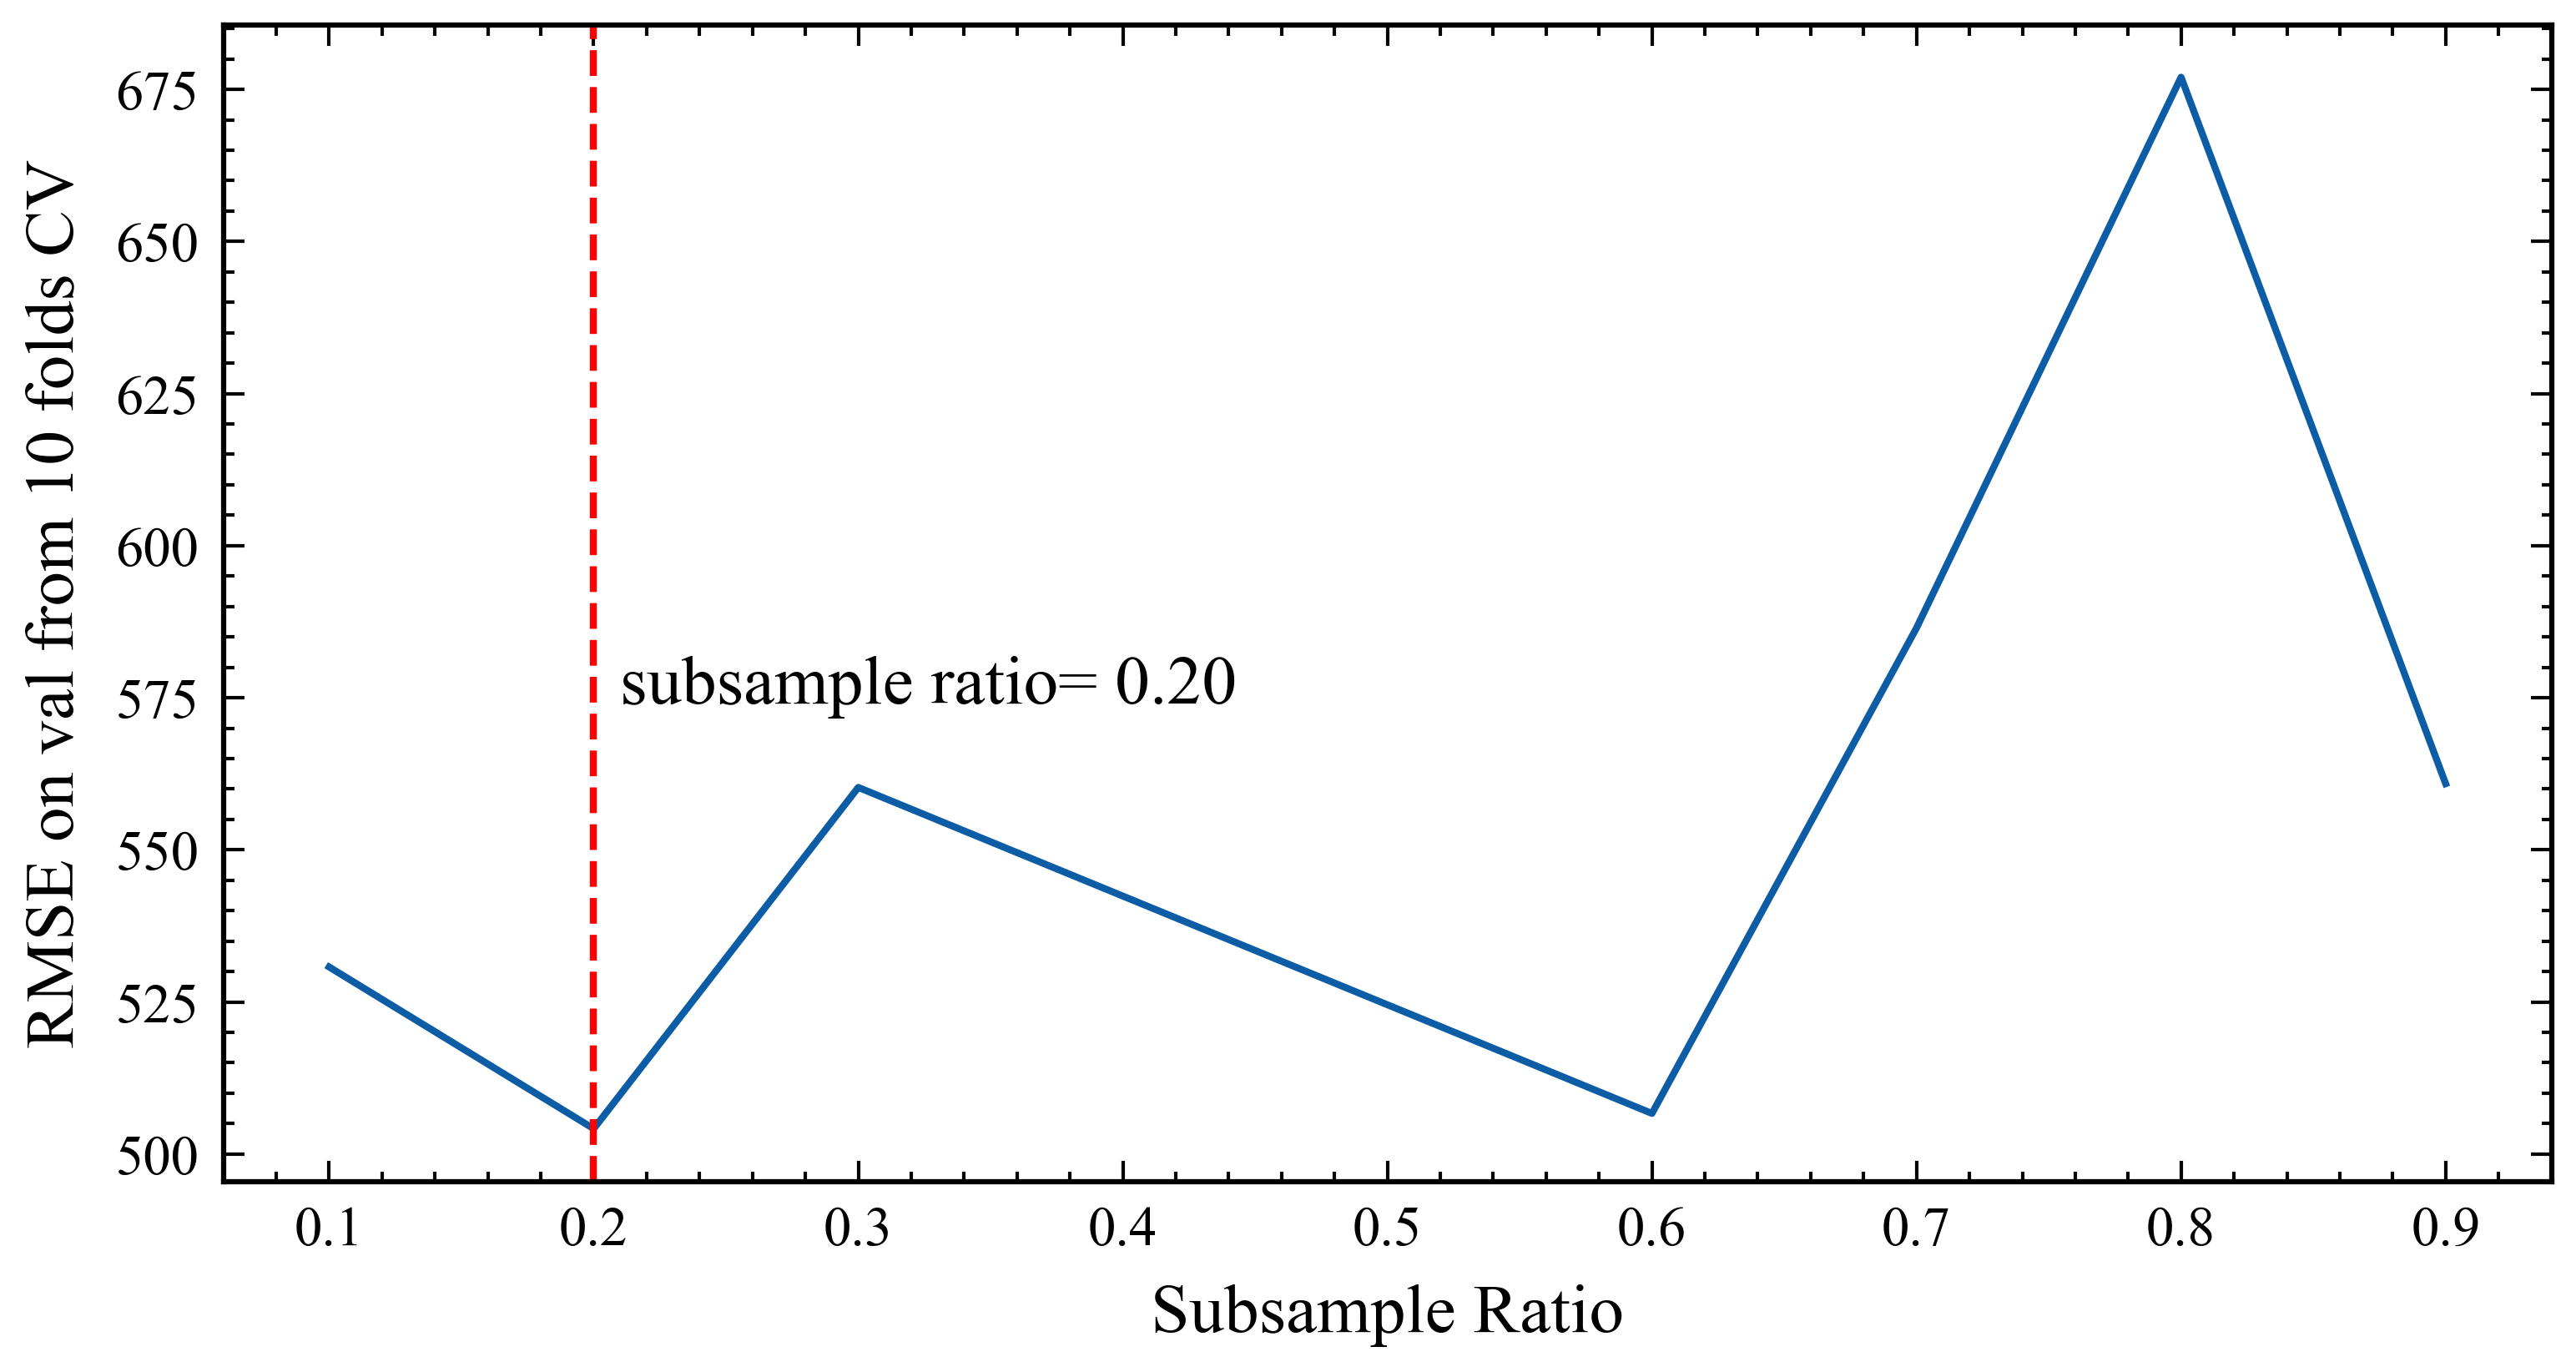

In [149]:
subsamples = sorted(search.cv_results_['param_subsample'])
scores = []
for s in subsamples:
    scores.append(-1*np.mean([search.cv_results_['mean_train_score'][k] 
                                for k in [i for i, x in enumerate(search.cv_results_['param_subsample']) 
                                          if x == s]])) 
    
plt.figure(figsize=(6, 3), dpi=300)    
plt.plot(subsamples,scores)
plt.axvline(x=subsamples[np.argmin(scores)], color='red', linestyle='--')
plt.text(subsamples[np.argmin(scores)] + 0.01, np.min(scores) + 70, f'subsample ratio= {subsamples[np.argmin(scores)]:.2f}')
plt.xlabel('Subsample Ratio')
plt.ylabel('RMSE on val from 10 folds CV')
plt.xticks(size=8)
plt.yticks(size=8)
plt.savefig('Q8_3.pdf', dpi=500, bbox_inches='tight')
plt.show()

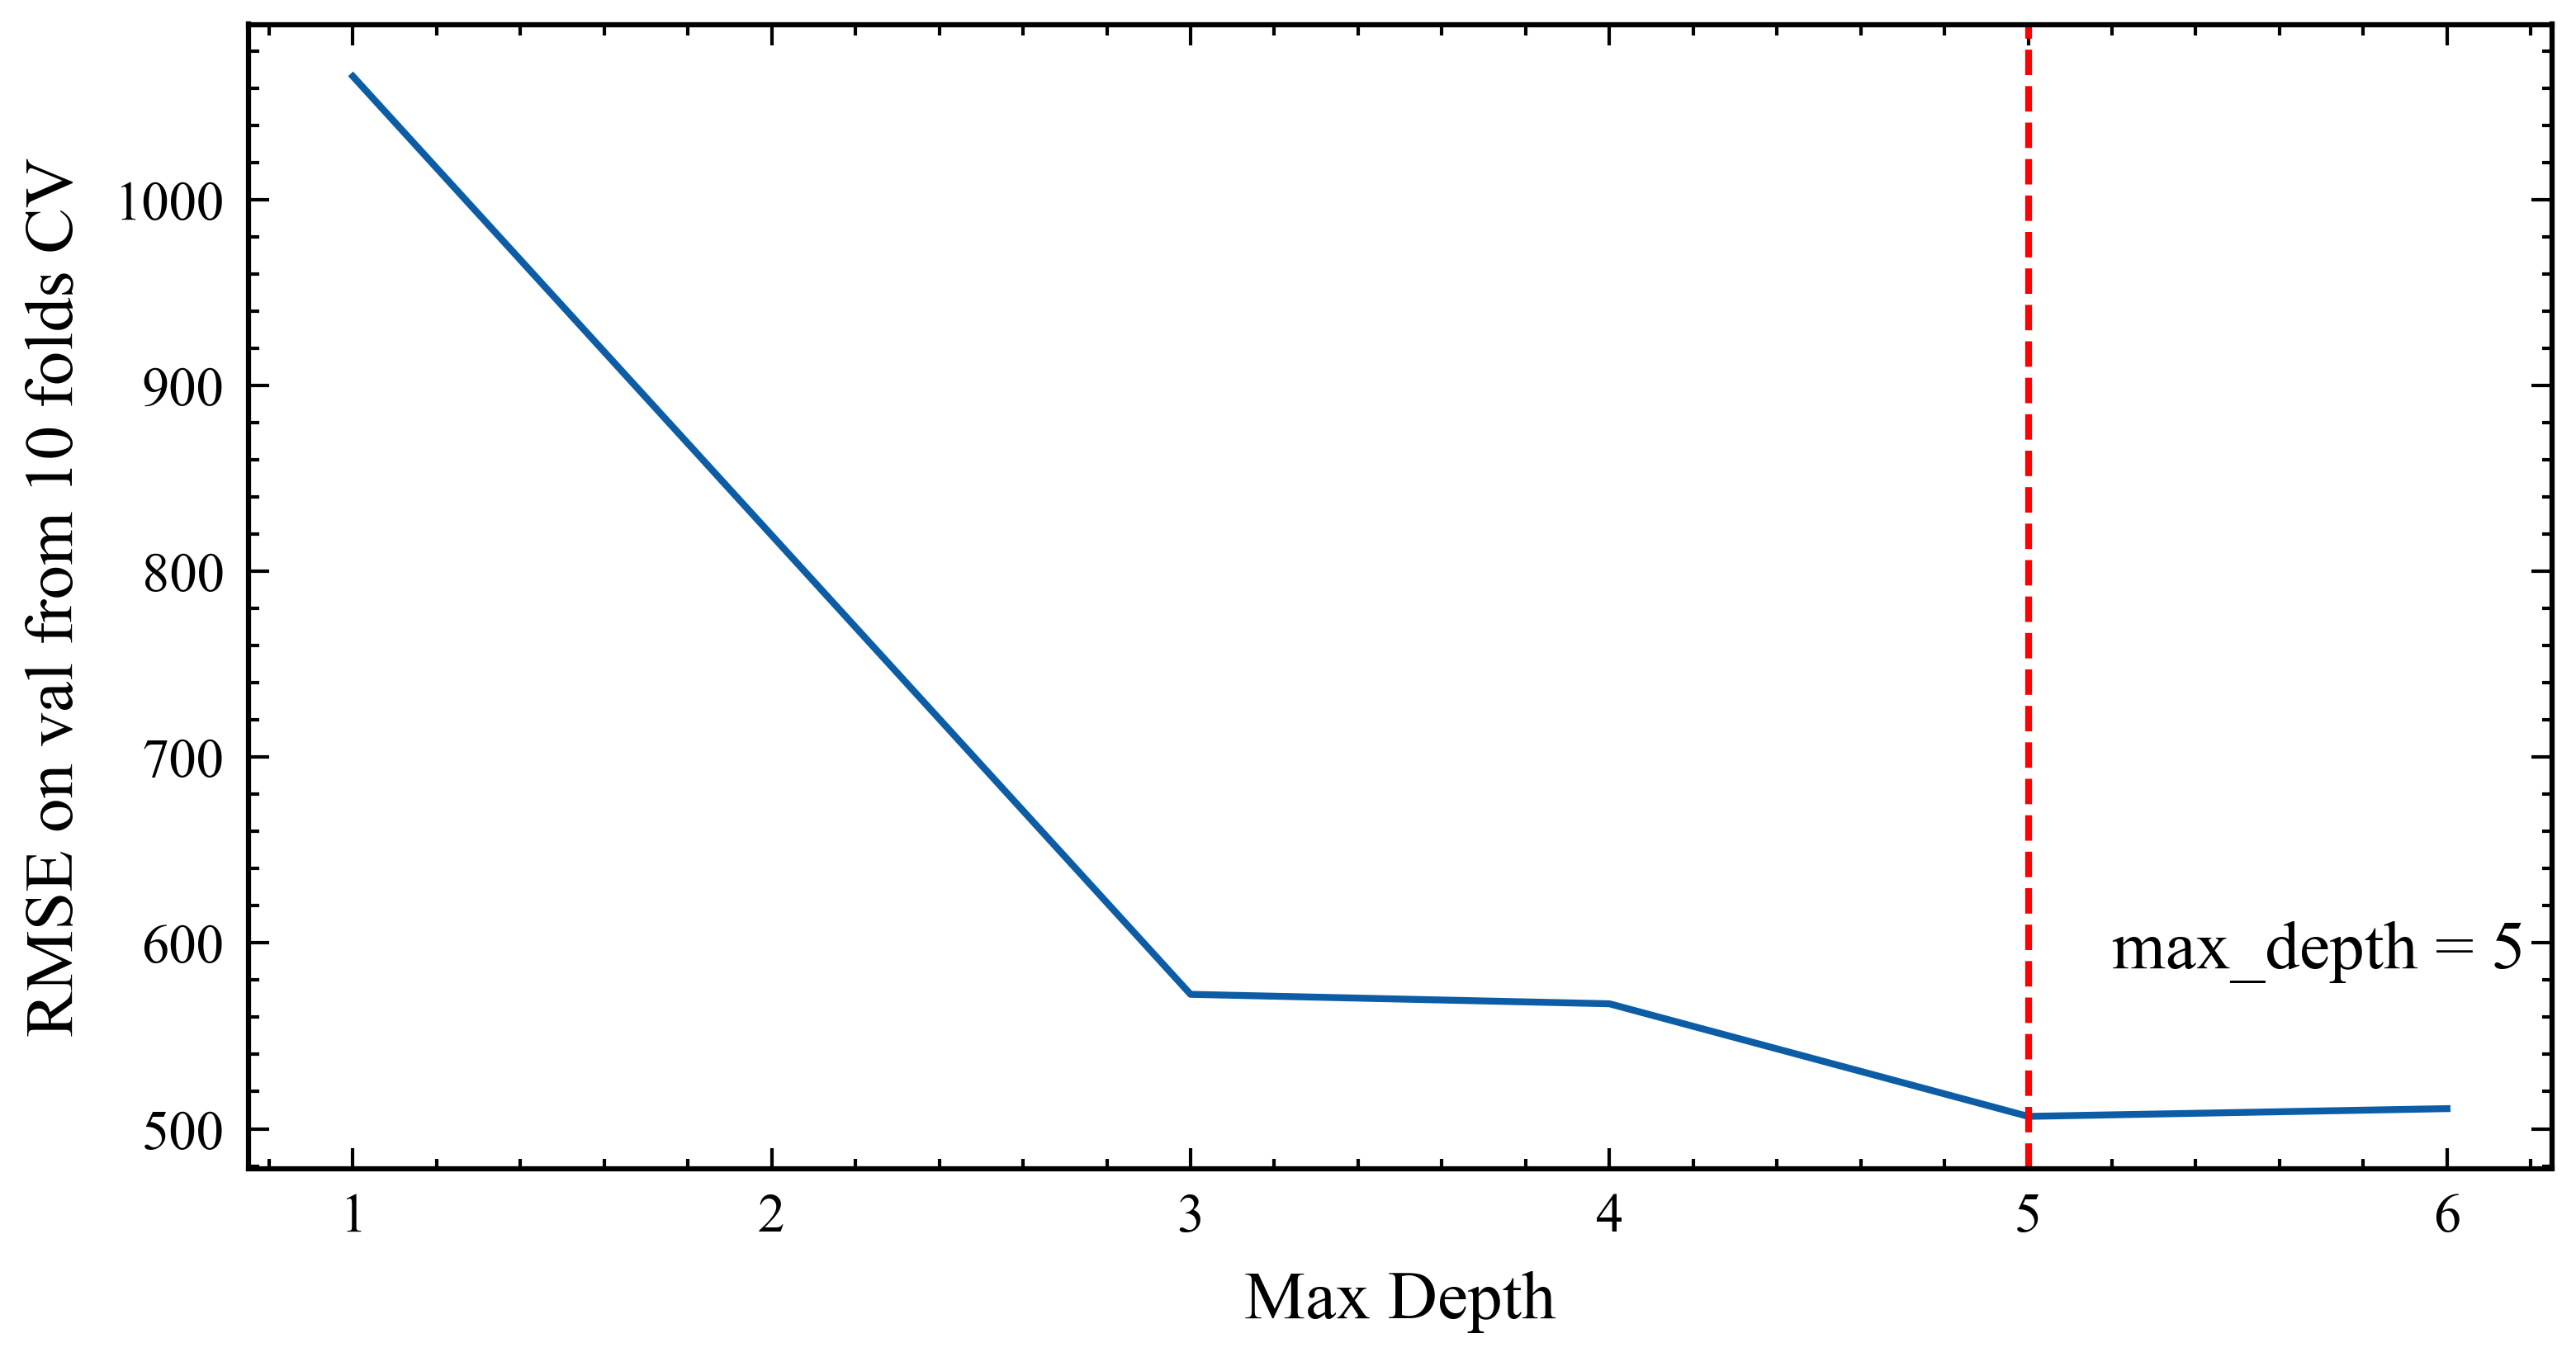

In [150]:
depths= sorted(search.cv_results_['param_max_depth'])
scores = []
for d in depths:
    scores.append(-1*np.mean([search.cv_results_['mean_train_score'][k] 
                                for k in [i for i, x in enumerate(search.cv_results_['param_max_depth']) 
                                          if x == d]])) 
    
plt.figure(figsize=(6, 3), dpi=300)    
plt.plot(depths,scores)
plt.axvline(x=depths[np.argmin(scores)], color='red', linestyle='--')
plt.text(depths[np.argmin(scores)] + 0.2, np.min(scores) + 80, f'max_depth = {depths[np.argmin(scores)]:.0f}')
plt.xlabel('Max Depth')
plt.ylabel('RMSE on val from 10 folds CV')
plt.xticks(size=8)
plt.yticks(size=8)
plt.savefig('Q8_4.pdf', dpi=500, bbox_inches='tight')
plt.show()

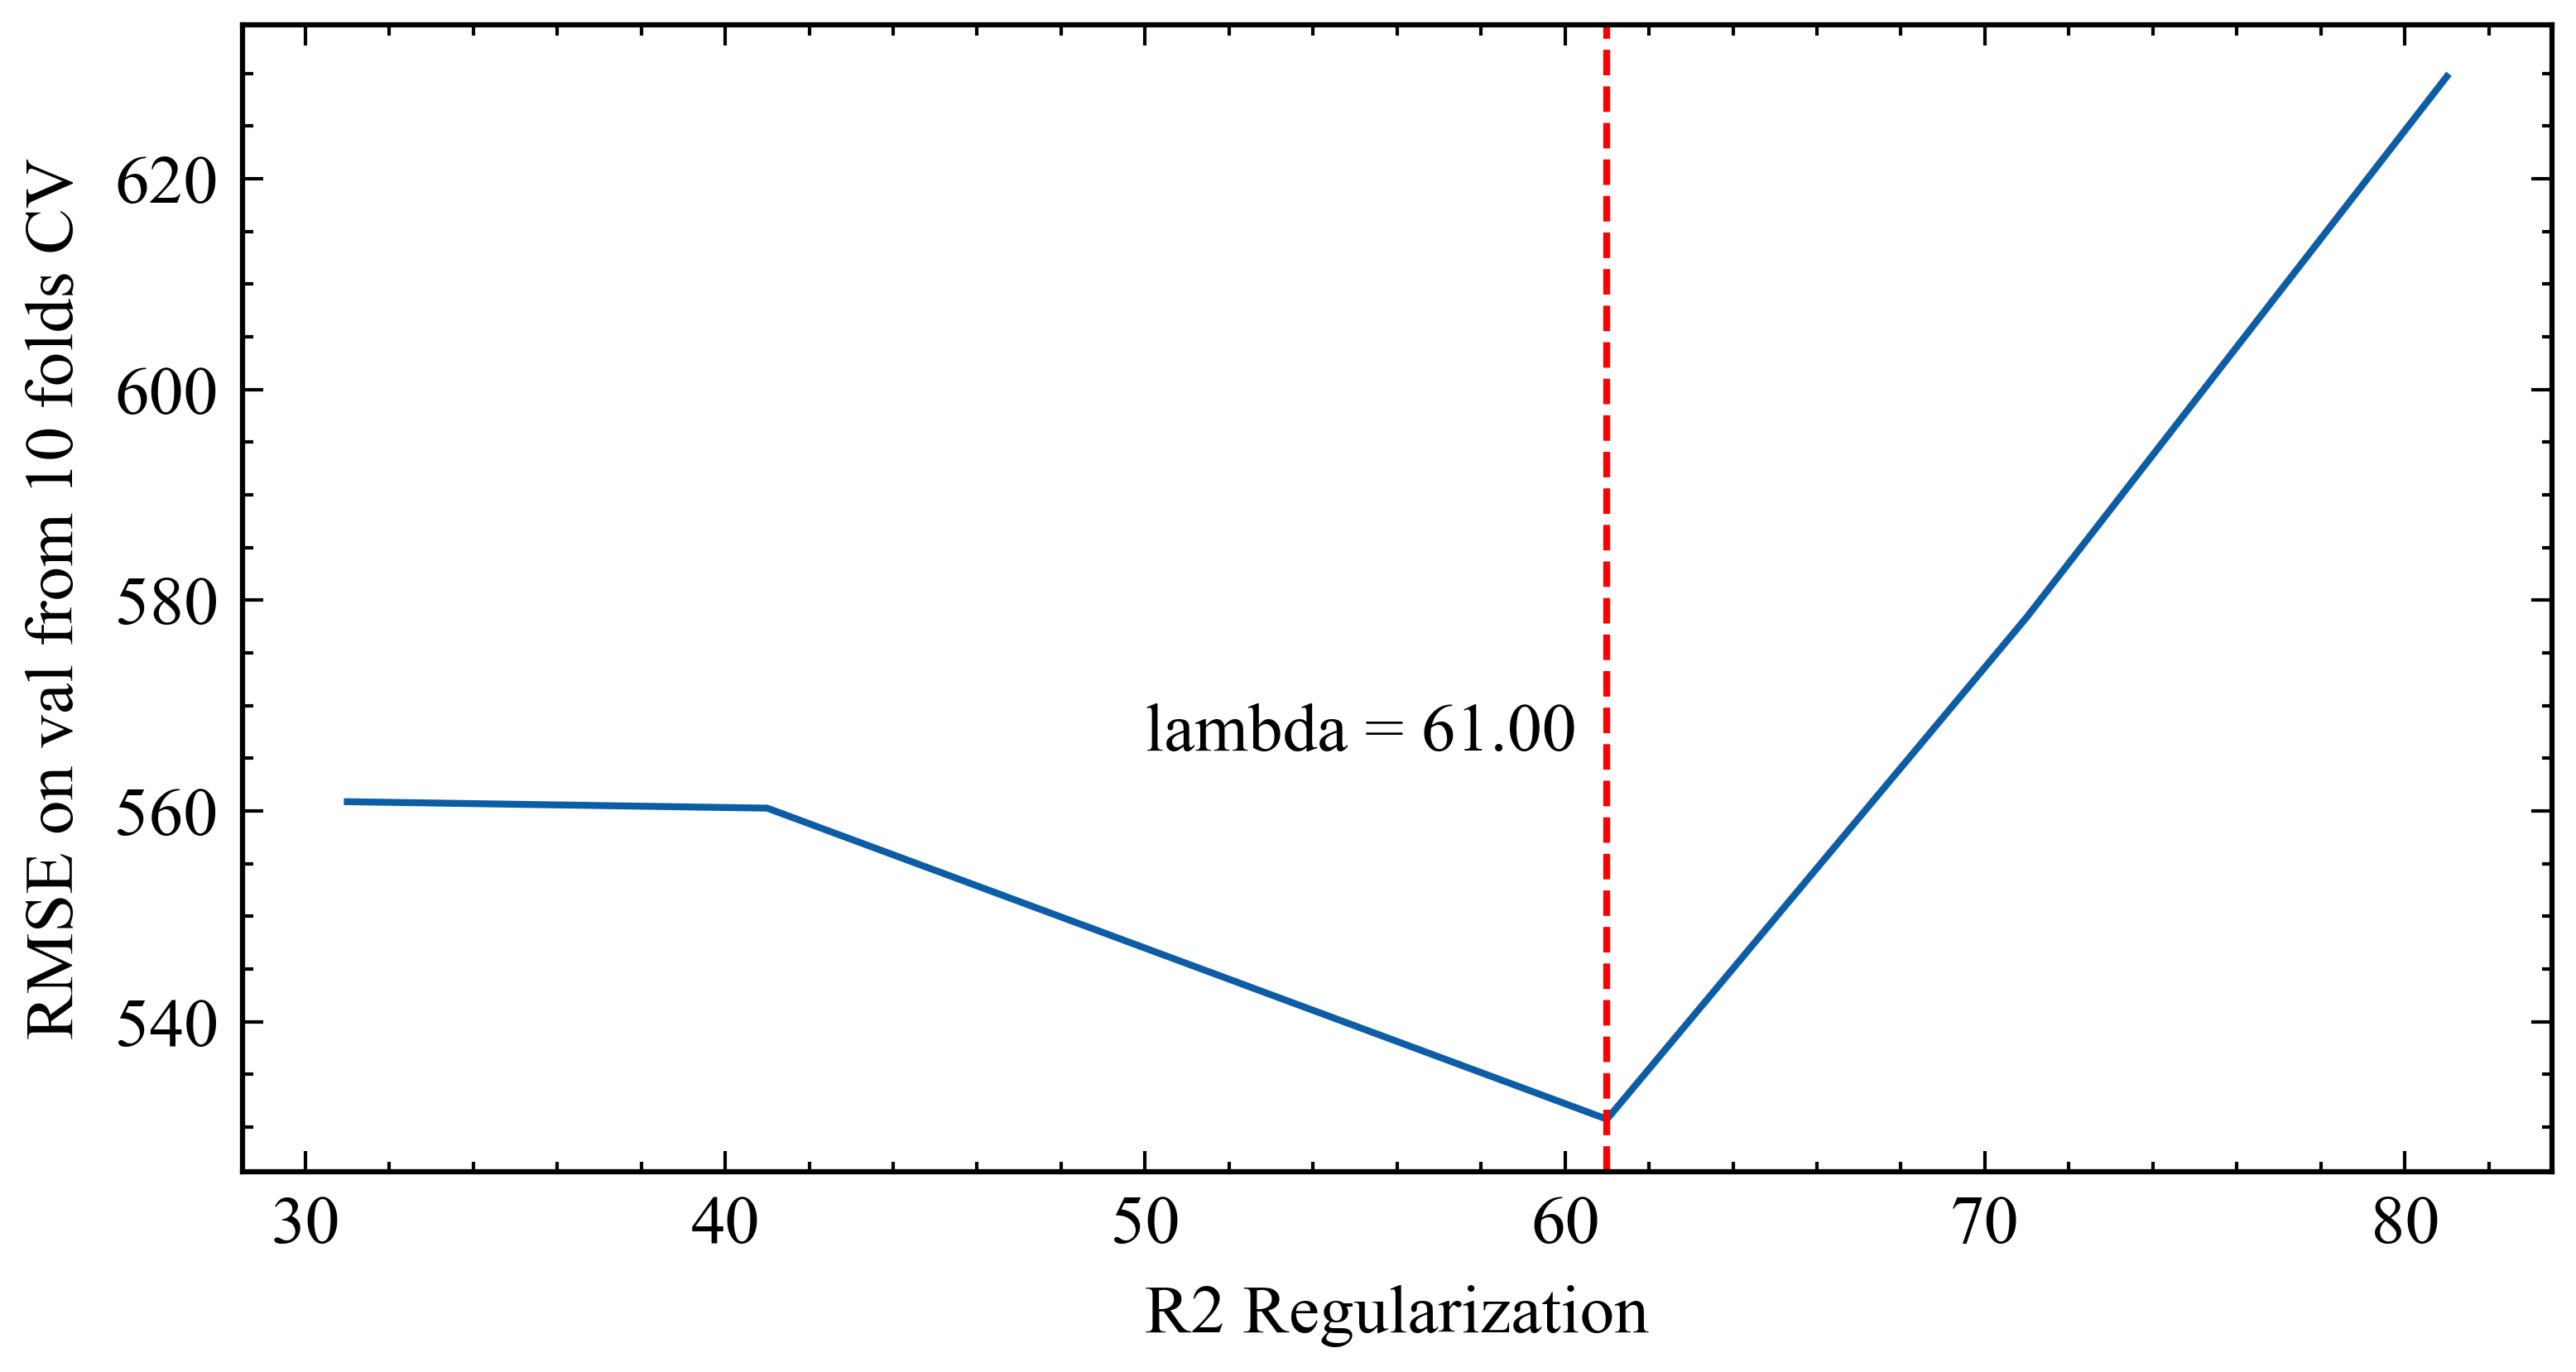

In [153]:
lambdas = sorted(search.cv_results_['param_reg_lambda'])
scores = []
for l in lambdas:
    scores.append(-1*np.mean([search.cv_results_['mean_train_score'][k] 
                                for k in [i for i, x in enumerate(search.cv_results_['param_reg_lambda']) 
                                          if x == l]])) 
plt.figure(figsize=(6, 3), dpi=300)    
plt.plot(lambdas,scores)
plt.axvline(x=lambdas[np.argmin(scores)], color='red', linestyle='--')
plt.text(lambdas[np.argmin(scores)] - 11, np.min(scores) + 35, f'lambda = {lambdas[np.argmin(scores)]:.2f}')
plt.xlabel('R2 Regularization')
plt.ylabel('RMSE on val from 10 folds CV')
plt.xticks(size=10)
plt.yticks(size=10)
plt.savefig('Q8_5.pdf', dpi=500, bbox_inches='tight')
plt.show()

Effect of hyperparameters of model performance, efficiency and regularization addressed in section 8.1

## Twitter content plots

In [64]:
t_epoch = np.load('train_epochs.npy')
t_loss = np.load('train_loss.npy')
e_epoch = np.load('valid_epochs.npy')
e_loss = np.load('valid_loss.npy')
ppl = np.load('ppl.npy')

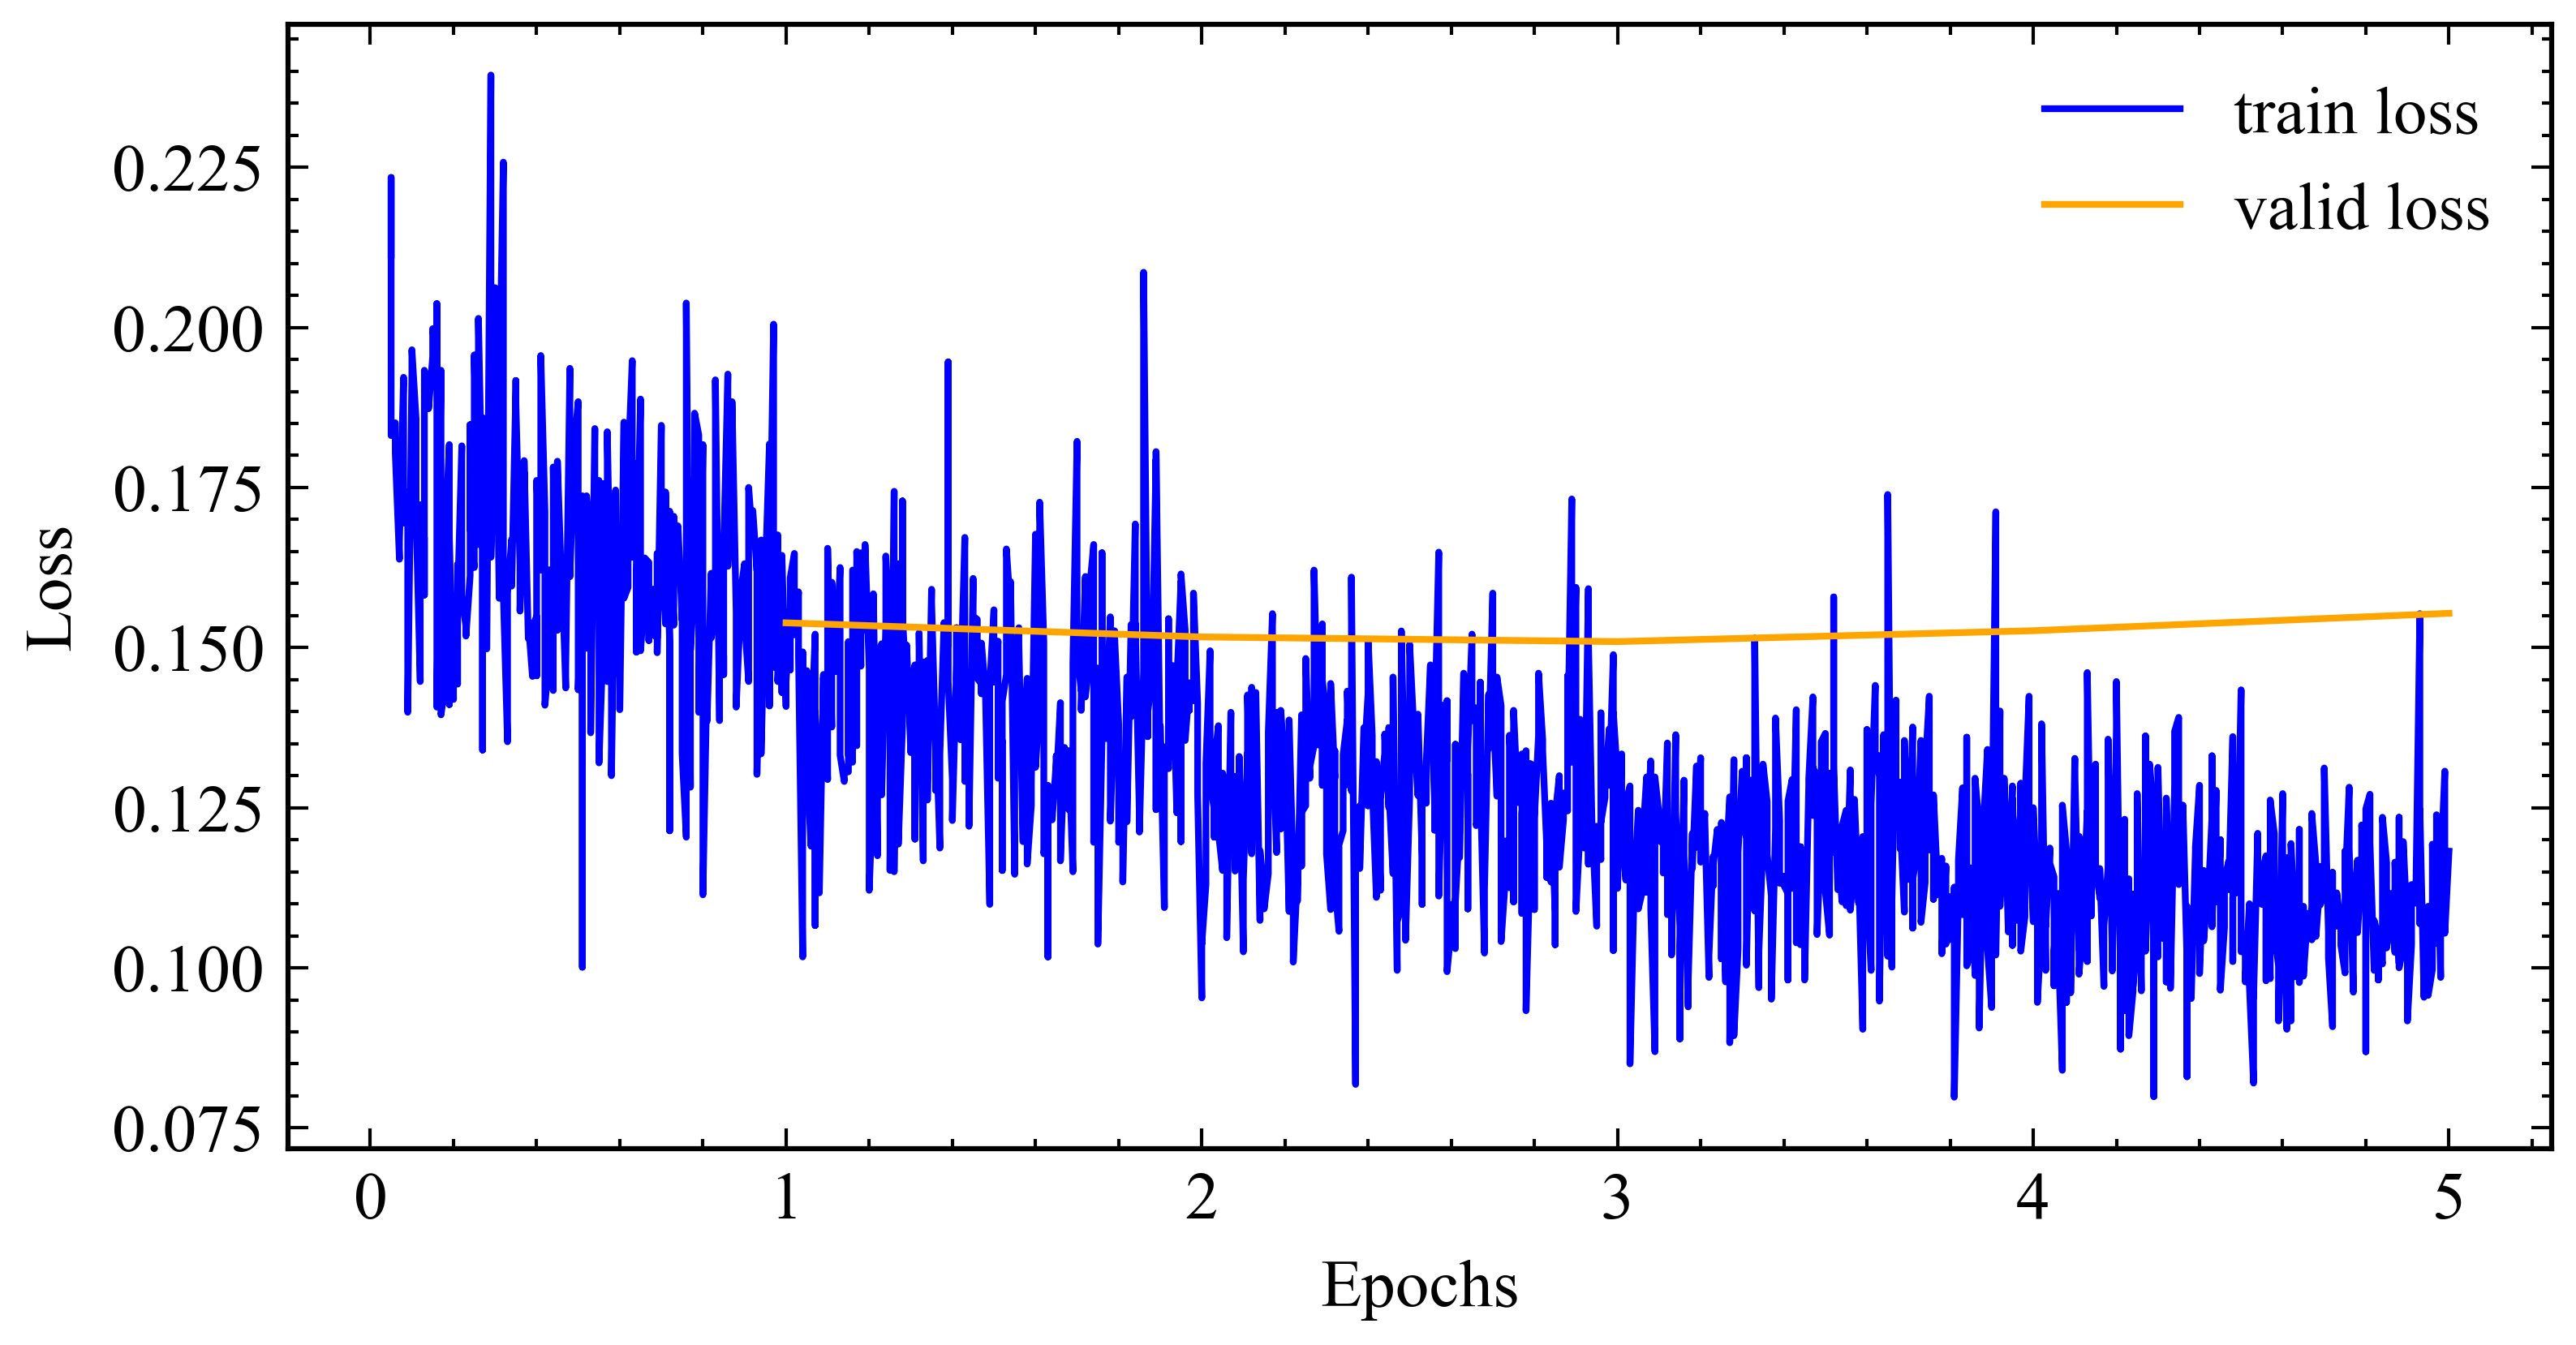

In [69]:
plt.figure(figsize=(6, 3), dpi=300)
plt.plot(t_epoch, t_loss, color = 'blue', label = 'train loss')
plt.plot(e_epoch, e_loss, color = 'orange', label = 'valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Q10_1.pdf', dpi=500, bbox_inches='tight')
plt.show()

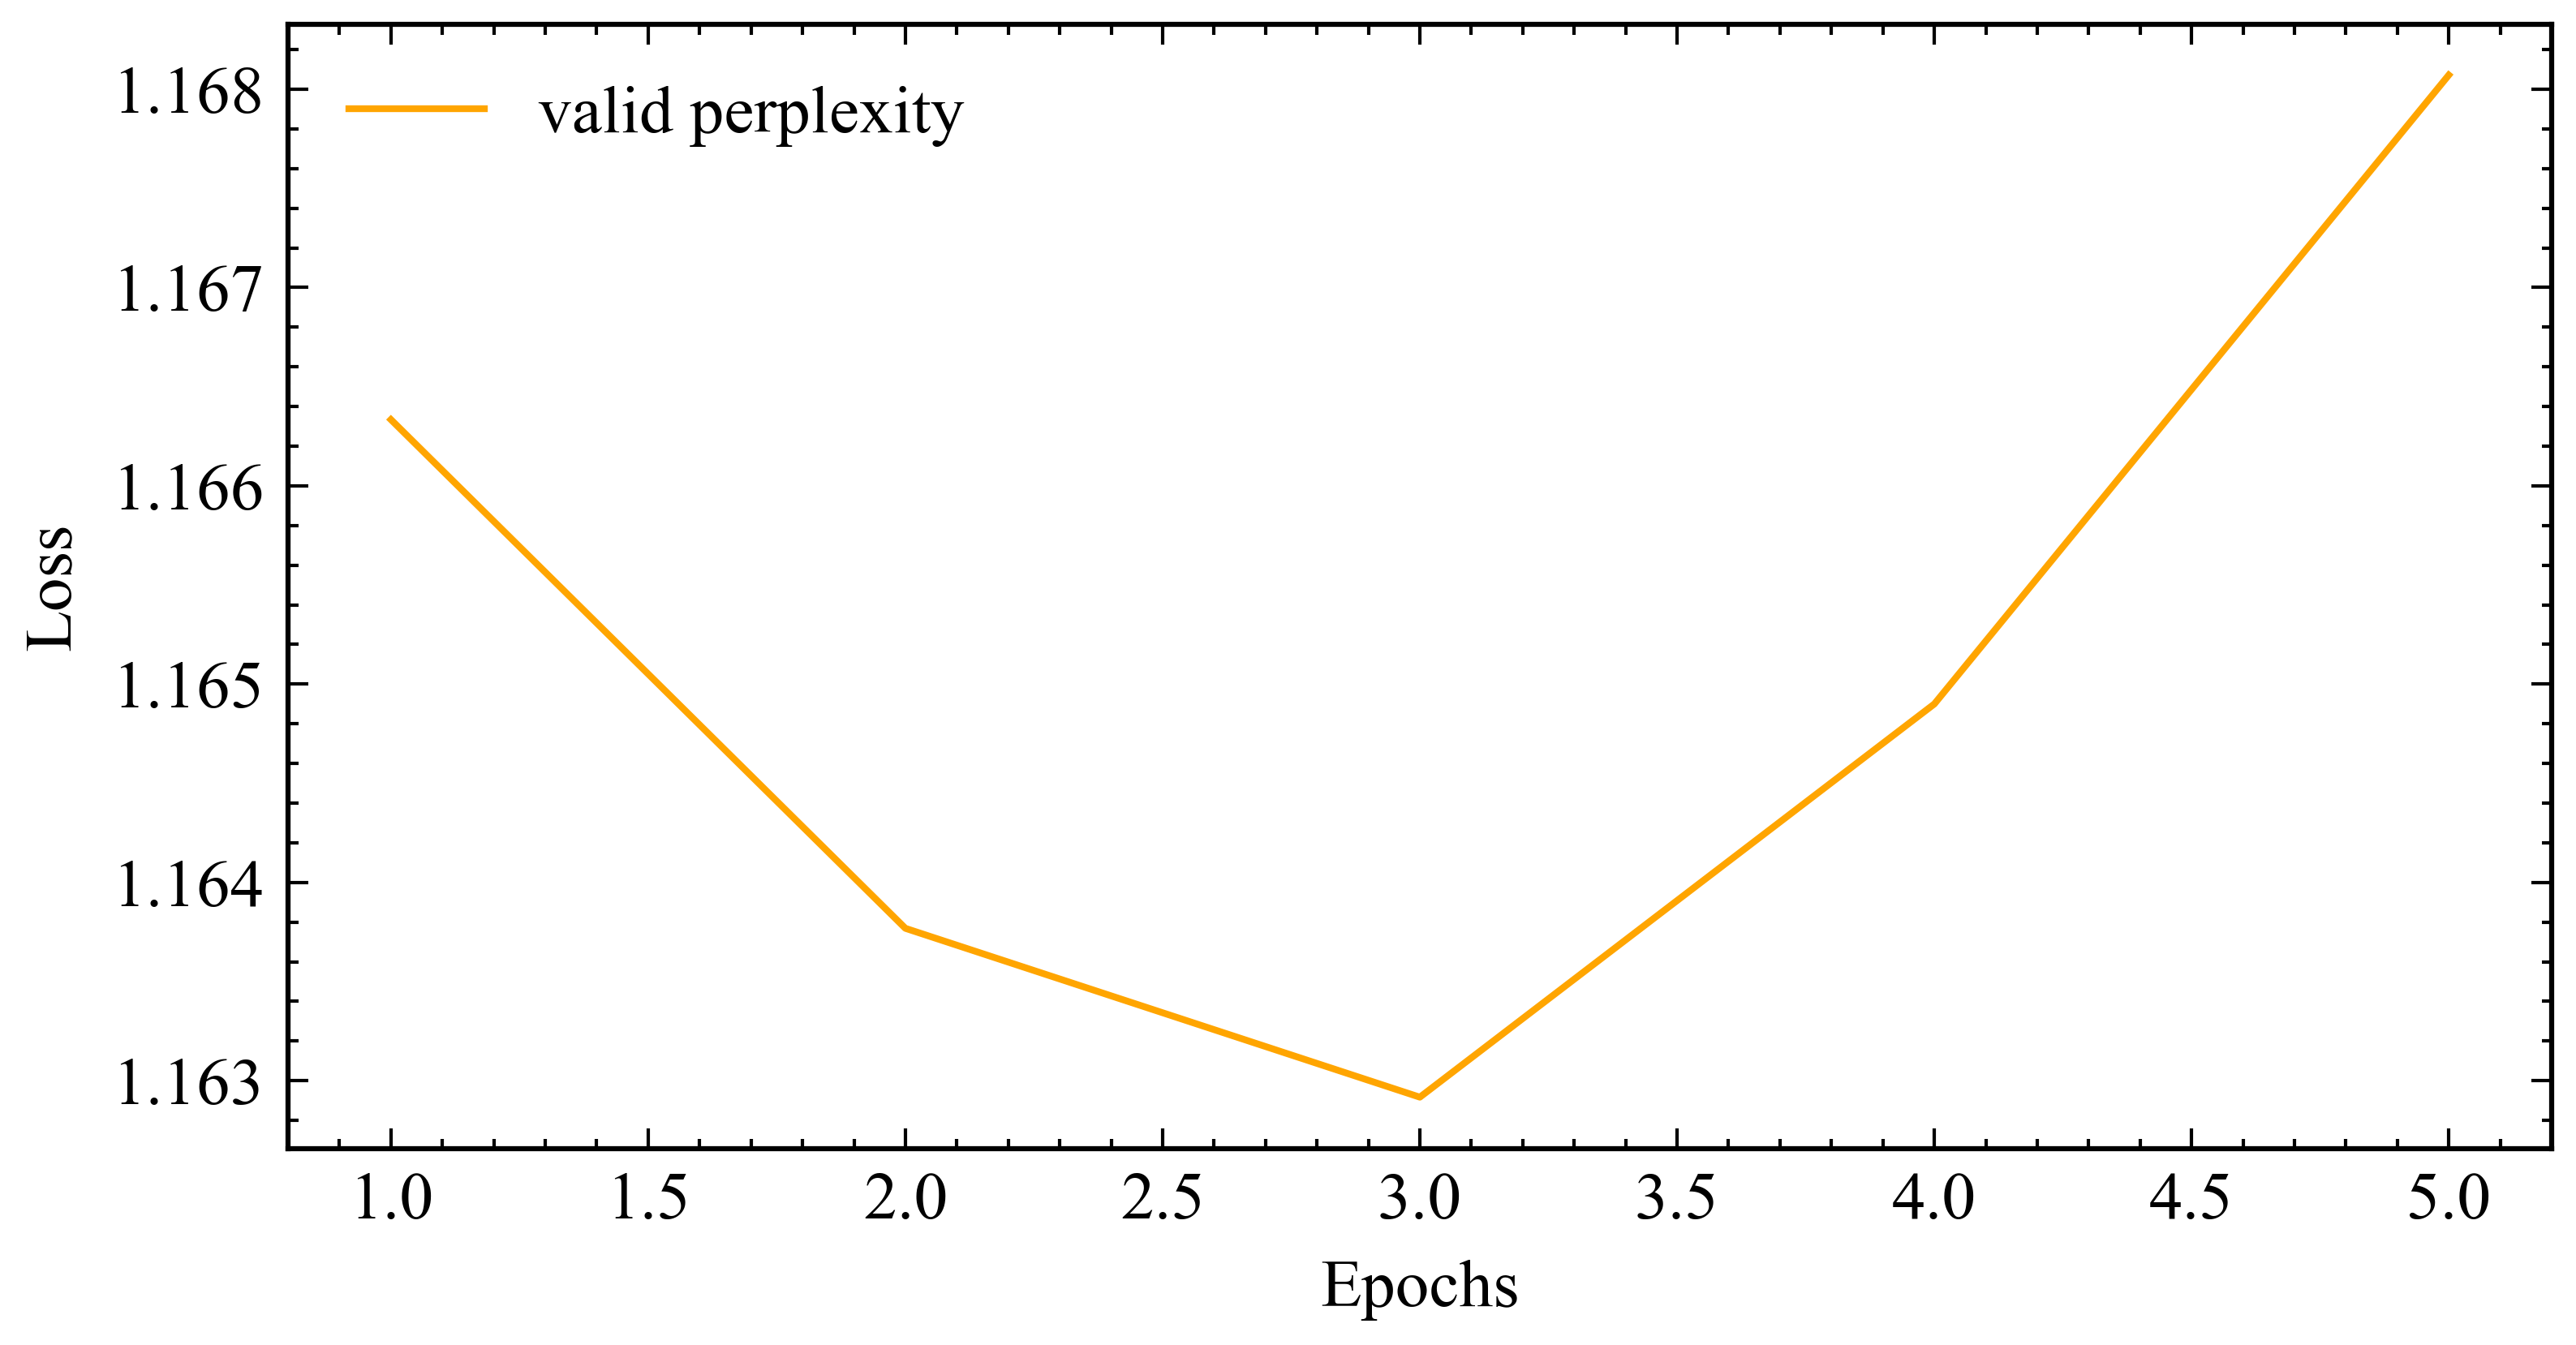

In [70]:
plt.figure(figsize=(6, 3), dpi=300)
plt.plot(e_epoch, ppl, color = 'orange', label = 'valid perplexity')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Q10_2.pdf', dpi=500, bbox_inches='tight')
plt.show()